# Setup

In [208]:
# Parameters

## Years
start_year = 2015
end_year = 2022
base_year = end_year
years = range(start_year, end_year + 1)

## Grouping
young_age_cutoff=25
old_age_threshold=65

## Indexing
price_variable = 'mehir' # 'mehir' or 'omdan'

## Output
top_n = 10
comparison_year = end_year
comparison_level = 'primary'

## Folder Names
cex_data_folder="/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/"
folder_names_pathname='Data_clean/CEX_folder_names.csv'
age_groups_pathname='Data_clean/age_groups.csv'
prodcode_dict_pathname = 'Data_clean/prodcode_dictionary_c3-c399.csv'
cpi_data_pathname = 'Data_clean/cpi_data_with_prodcode_clean.csv'
    
## Libraries
import pandas as pd
import pyreadstat  
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Data

In [209]:
# Load folder names
folder_names_df = pd.read_csv(folder_names_pathname)

# Load age groups
age_groups_df = pd.read_csv(age_groups_pathname)
young_age_group_id = age_groups_df[(age_groups_df['min_age'] <= young_age_cutoff) & (age_groups_df['max_age'] >= young_age_cutoff)].index[0] + 1
old_age_group_id = age_groups_df[(age_groups_df['min_age'] <= old_age_threshold) & (age_groups_df['max_age'] >= old_age_threshold)].index[0] + 1

# Load household data for each year
dfs_mb = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_HH_pathname = f"{cex_data_folder}{subfolder}/{subfolder}datamb.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_HH_pathname)
    df.columns = df.columns.str.lower()
    if 'gil' in df.columns:
        df.rename(columns={'gil': 'age_group'}, inplace=True)
    df['misparmb'] = df['misparmb'].astype(int)
    dfs_mb[year] = df

# Load individual data for each year
dfs_prat = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_IND_pathname = f"{cex_data_folder}{subfolder}/{subfolder}dataprat.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_IND_pathname)
    df.columns = df.columns.str.lower()
    if 'gil' in df.columns:
        df.rename(columns={'gil': 'age_group'}, inplace=True)
    df['misparmb'] = df['misparmb'].astype(int)
    dfs_prat[year] = df

# Load expenses data for each year
dfs_prod = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_prices_pathname = f"{cex_data_folder}{subfolder}/{subfolder}dataprod.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_prices_pathname)
    df.columns = df.columns.str.lower()
    df['misparmb'] = df['misparmb'].astype(int)
    df['prodcode'] = df['prodcode'].astype(int).astype(str)
    dfs_prod[year] = df

# Load survey data for each year
dfs_survey = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_prices_pathname = f"{cex_data_folder}{subfolder}/{subfolder}datayoman.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_prices_pathname)
    df.columns = df.columns.str.lower()
    df['misparmb'] = df['misparmb'].astype(int)
    df['prodcode'] = df['prodcode'].astype(int).astype(str)
    dfs_survey[year] = df

# Grouping

## Data

In [210]:
Groups = {}
for year in years:
    Groups[year] = pd.DataFrame(dfs_mb[year]['misparmb'].unique(), columns=['misparmb'])

In [211]:
for year in years:
    dfs_mb_year = dfs_mb[year]
    dfs_prat_year = dfs_prat[year]

    nationality_map = {1: 'Jewish', 2: 'Arab'}
    observance_map = {1: 'Secular', 2: 'Conservative', 3: 'Religious', 4: 'Ultra-Orthodox', 5: 'Mixed'}


    Groups[year]['Nationality'] = dfs_mb_year['nationality'].map(nationality_map).fillna('Other')
    Groups[year]['Observance'] = dfs_mb_year['ramatdatiyut'].map(observance_map).fillna('Other')
    Groups[year].loc[Groups[year]['Nationality'] == 'Arab', 'Observance'] = 'Other'

    age_group_map = {age_group_id: '(1) Young' if age_group_id <= young_age_group_id else '(3) Old' if age_group_id >= old_age_group_id else '(2) Middle' for age_group_id in dfs_prat_year['age_group'].unique()}
    Groups[year]['Age_Group'] = dfs_prat_year.loc[dfs_prat_year['y_kalkali'] == 1, 'age_group'].map(age_group_map).values

    Groups[year]['Income_Decile'] = dfs_mb_year['decile'].fillna(0).astype(int)

    Groups[year]['Income_Quintile'] = pd.cut(dfs_mb_year['decile'], bins=[0, 2, 4, 6, 8, 10], labels=[1, 2, 3, 4, 5])

    Groups[year]['SES_Quintile'] = dfs_mb_year['cluster'].apply(lambda x: x if x in range(1, 6) else np.nan).fillna(0).astype(int)
    Groups[year]['SES_Groups'] = Groups[year]['SES_Quintile'].apply(lambda x: '(1) Low' if x in [1, 2] else '(2) Medium' if x == 3 else '(3) High' if x in [4, 5] else np.nan)

    Groups[year]['Children'] = dfs_mb_year['nefashotad18'].fillna(0).astype(int)
    Groups[year]['Family_Size'] = Groups[year]['Children'].apply(lambda x: '0 children' if x == 0 else '1-3 children' if x in [1, 2, 3] else '4+ children')

## Groups Dataframes Headers

In [212]:
display(HTML(f"<h2>Groups for Year {end_year}</h2>"))
display(HTML(Groups[year].head().to_html(index=False)))
print(f"Number of observations: {len(dfs_mb[end_year])}")

misparmb,Nationality,Observance,Age_Group,Income_Decile,Income_Quintile,SES_Quintile,SES_Groups,Children,Family_Size
57089,Jewish,Conservative,(3) Old,3,2,3,(2) Medium,0,0 children
57090,Jewish,Secular,(3) Old,7,4,3,(2) Medium,0,0 children
57091,Jewish,Secular,(2) Middle,2,1,3,(2) Medium,3,1-3 children
57092,Jewish,Secular,(2) Middle,4,2,3,(2) Medium,1,1-3 children
57093,Arab,Other,(2) Middle,10,5,3,(2) Medium,0,0 children


Number of observations: 5478


## Plot Groups Distribution

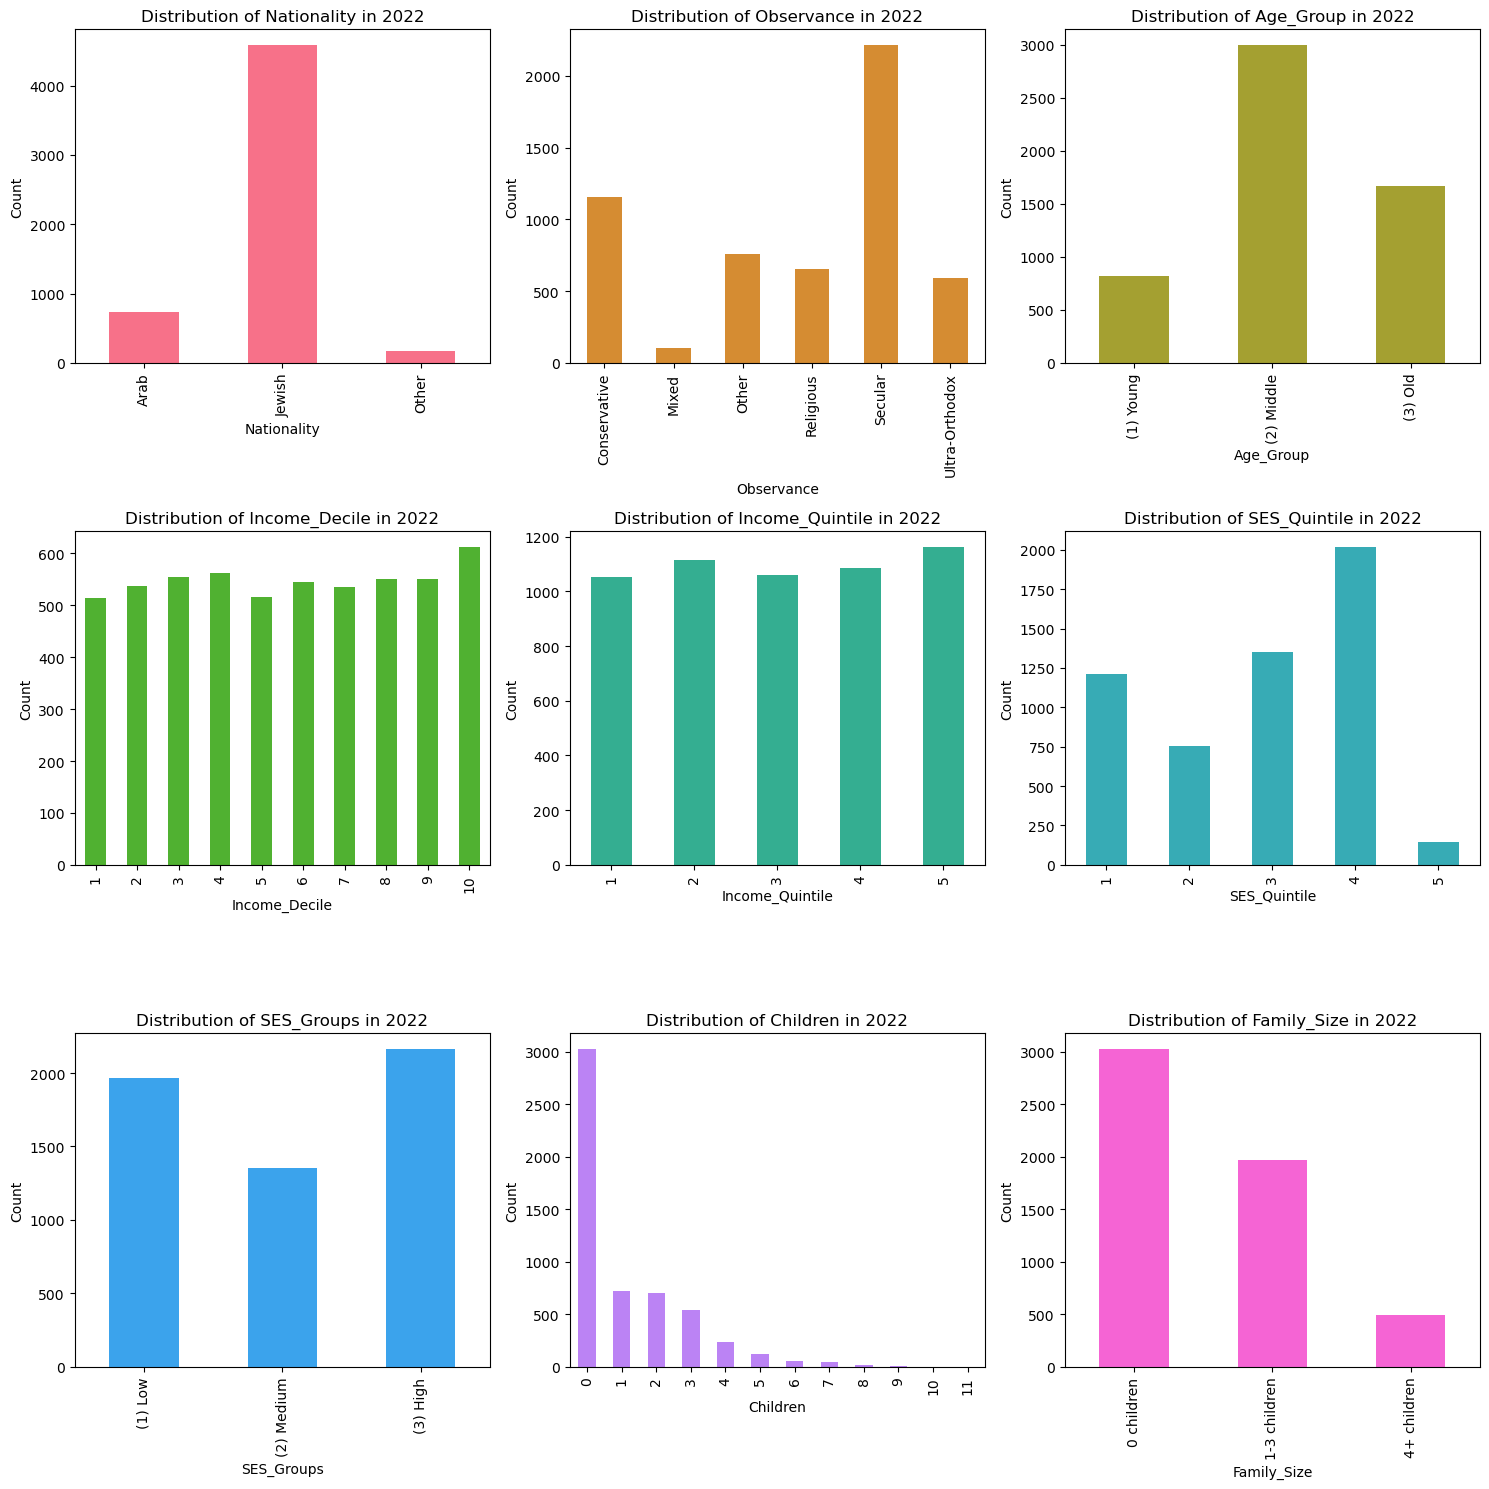

In [213]:
import seaborn as sns

# Get the columns to plot
columns_to_plot = [col for col in Groups[end_year].columns if col != 'misparmb']

# Calculate the number of rows needed
ncols = 3
nrows = (len(columns_to_plot) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a color palette
palette = sns.color_palette("husl", len(columns_to_plot))

# Plot each column
for ax, column, color in zip(axes, columns_to_plot, palette):
    Groups[end_year][column].value_counts().sort_index().plot(kind='bar', ax=ax, color=color)
    ax.set_title(f'Distribution of {column} in {end_year}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Remove any unused subplots
for ax in axes[len(columns_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# Indexing

## Laspeyres Index

For good $j$, at time $t$:

$$
I_{t}=\frac{\sum_{j\in L}{\frac{P_{tj}}{P_{oj}}(P_{oj}Q_{oj})}}{\sum_{j\in L}P_{oj}Q_{oj}}\times 100
$$

$$\text{For our purposes:}$$

$$
I_{tj}=\frac{P_{tj}}{P_{oj}}
$$
$$
W_{oj}=\frac{P_{oj}Q_{oj}}{\sum_{j\in L}P_{oj}Q_{oj}}
$$
$$
I_{t}=\sum_{j\in L}W_{oj}I_{tj}\times 100
$$



$$
\text{Where:}\\
I_{t}\text{  - Index for period t}\\
Q_{oj}\text{  - Quantity of the good or service in the base period}\\
P_{oj}\text{  - Price of the good or service in the base period}\\
P_{tj}\text{  - Price of the good or service in period t}\\
L\text{  - The set of all goods and services in the index basket}\\
$$

## Calculate Weights

In [214]:
# Drop unnecessary groups
for year in years:
    Groups[year] = Groups[year].drop(columns=['Income_Decile', 'SES_Quintile', 'Children'])

# Drop unnecessary subgroups
for year in years:
    Groups[year] = Groups[year][~Groups[year]['Observance'].isin(['Mixed'])]
    Groups[year] = Groups[year][Groups[year]['Nationality'] != 'Other']

In [215]:
def calculate_weights(product_level, year, group_mmb = None):
    # Expenses dataframe for consumption expenses only
    expenses_df = dfs_prod[year][dfs_prod[year]['prodcode'].astype(str).str.startswith('3')].copy()

    if group_mmb is not None:
        # Filter only IDs that match the group
        expenses_df = expenses_df[expenses_df['misparmb'].isin(group_mmb)].reset_index(drop=True)

    # Keep only the product codes at the correct product level
    expenses_df = expenses_df[expenses_df['prodcode'].str.len() == product_level]

    # Sum the expense for each prodcode
    expenses_df = expenses_df.groupby('prodcode')['schum'].sum().reset_index()

    # Calculate weights
    expenses_df['weight'] = expenses_df['schum'] / expenses_df['schum'].sum()

    return expenses_df

In [216]:
product_level = 6
year = base_year

weights = {}
for group in Groups[year].columns[1:]:
    weights[group] = {}  
    for subgroup in Groups[year][group].unique():
        mmb = Groups[year][Groups[year][group] == subgroup]['misparmb']
        weights[group][subgroup] = calculate_weights(product_level, year, mmb)
weights['All'] = {'All': calculate_weights(product_level, year, None)}

In [217]:
# Check if the weights sum to 1.0
for group in weights:
    for subgroup in weights[group]:
        if weights[group][subgroup]['weight'].sum()!=1.0:
            print(f"Warning: Weights for {group} {subgroup} do not sum to 1.0. They sum to {weights[group][subgroup]['weight'].sum()}")

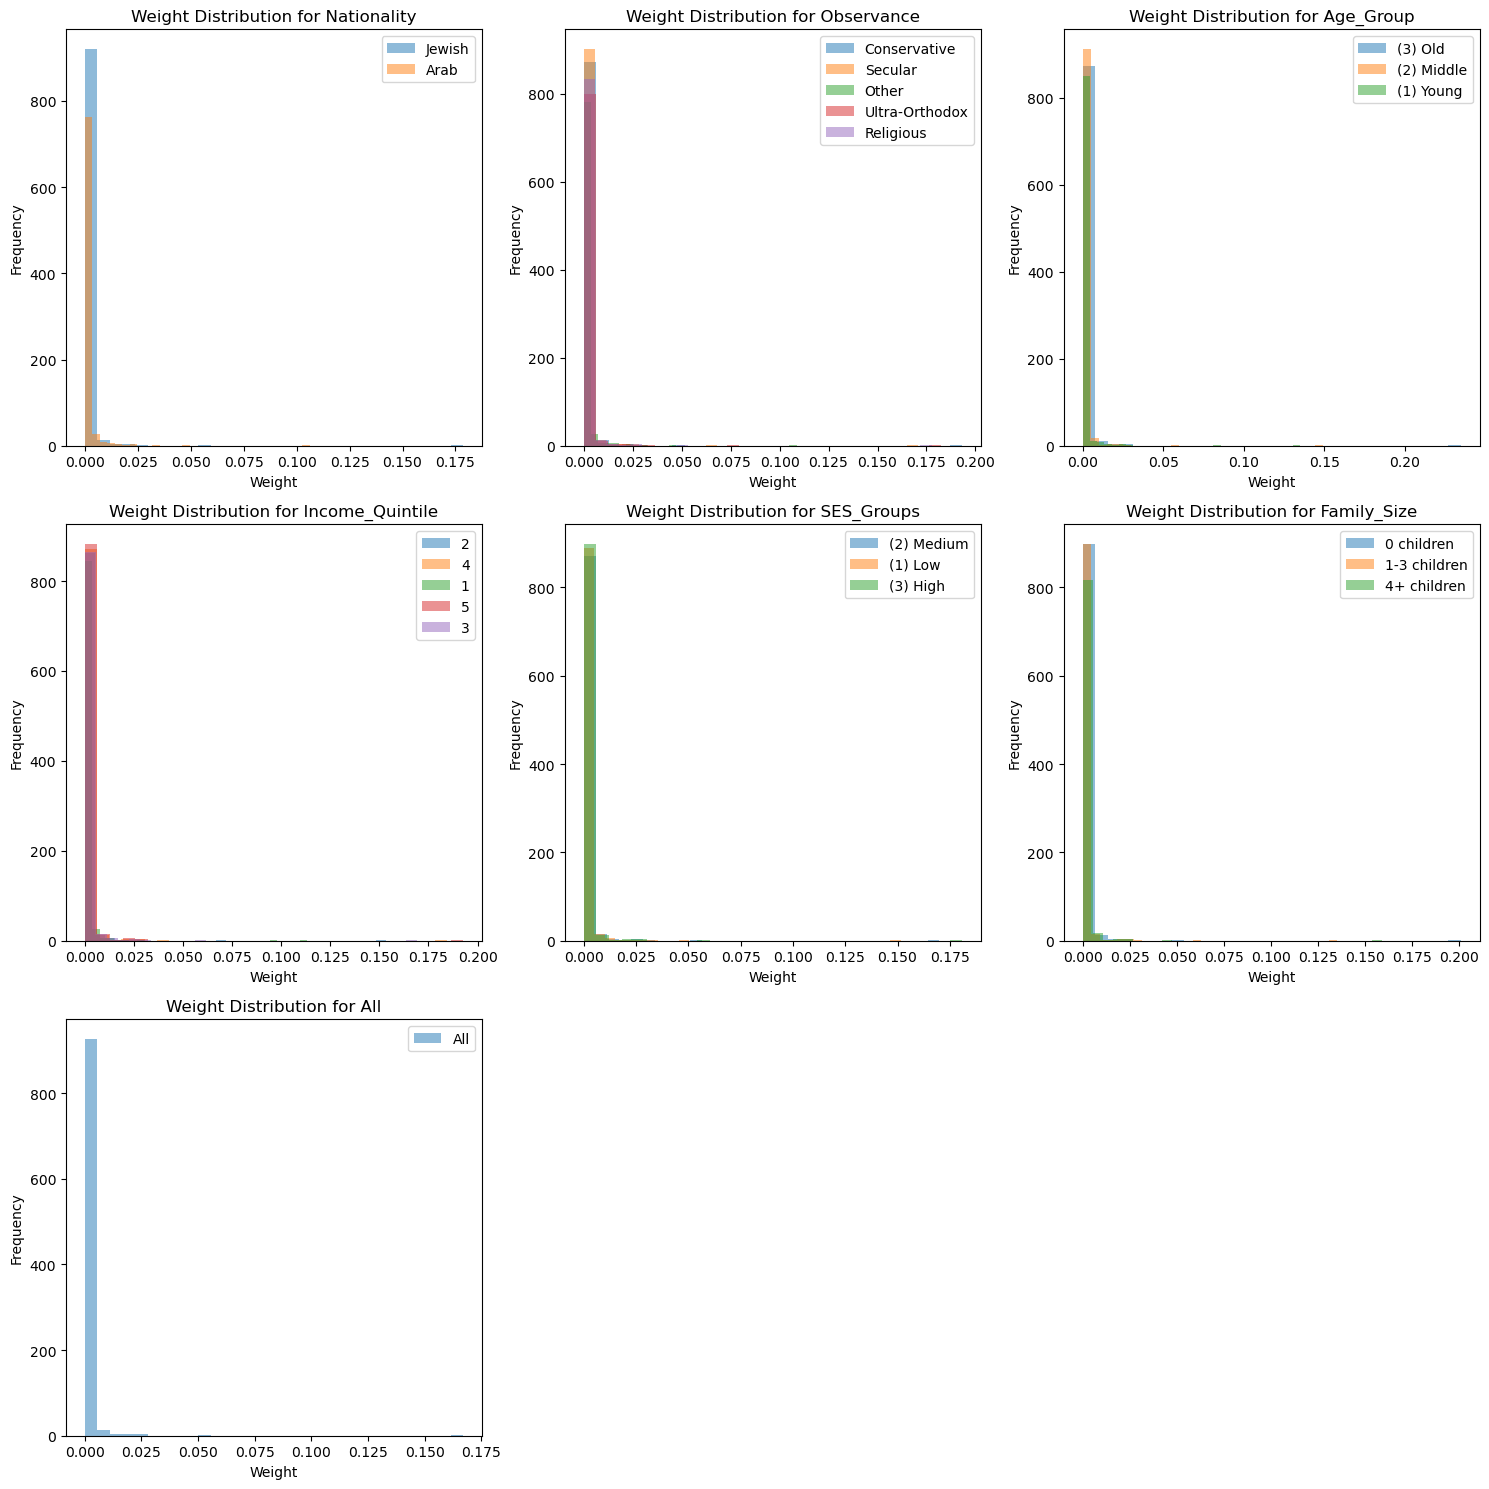

In [218]:
# Define the groups to plot
groups_to_plot = list(weights.keys())

# Calculate the number of rows needed
ncols = 3
nrows = (len(groups_to_plot) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
axes = axes.flatten()

# Plot each group
for ax, group in zip(axes, groups_to_plot):
    subgroups = weights[group].keys()
    for subgroup in subgroups:
        weight_values = weights[group][subgroup]['weight']
        ax.hist(weight_values, bins=30, alpha=0.5, label=subgroup)
    ax.set_title(f'Weight Distribution for {group}')
    ax.set_xlabel('Weight')
    ax.set_ylabel('Frequency')
    ax.legend()

# Remove any unused subplots
for ax in axes[len(groups_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## Prices

In [219]:
def calculate_prices(year, group_mmb = None):
    # Prices dataframe for consumption expenses only
    prices_df = dfs_survey[year][dfs_survey[year]['prodcode'].astype(str).str.startswith('3')].copy()

    if group_mmb is not None:
        # Filter only IDs that match the group
        prices_df = prices_df[prices_df['misparmb'].isin(group_mmb)].reset_index(drop=True)

    # Calculate prices
    prices_df['price'] = prices_df['mehir'] / prices_df['kamut']
    prices_df['price'] = prices_df['price'].replace([np.inf, 0], np.nan)

    # Group by product code and calculate the mean price, standard deviation, min and max
    prices_df = prices_df.groupby('prodcode', as_index=False).agg({'price': ['mean', 'std', 'min', 'max']})
    prices_df.columns = ['prodcode', 'price', 'price_std', 'price_min', 'price_max']    

    return prices_df

In [220]:
prices = {}
for year in years:
    prices[year] = {}
    for group in Groups[year].columns[1:]:
        prices[year][group] = {}
        for subgroup in Groups[year][group].unique():
            mmb = Groups[year][Groups[year][group] == subgroup]['misparmb']
            prices[year][group][subgroup] = calculate_prices(year, mmb)
    prices[year]['All'] = {'All': calculate_prices(year, None)}

In [221]:
def calculate_indexes(weights, prices, prices_base):
    
    # Organize dataframes
    prices_base = prices_base.drop(columns=['price_std', 'price_min', 'price_max'])
    prices = prices.drop(columns=['price_std', 'price_min', 'price_max'])
    prices_base = prices_base.rename(columns={'price': 'price_base'})
    weights = weights.drop(columns=['schum'])

    # Merge weights and prices dataframes
    merged_df = weights.merge(prices, on='prodcode', how='left')
    merged_df = merged_df.merge(prices_base[['prodcode', 'price_base']], on='prodcode', how='left')

    # Calculate price divided by the base year price
    merged_df['price_ratio'] = merged_df['price'] / merged_df['price_base']
    merged_df['price_ratio'] = merged_df['price_ratio'].fillna(1)

    return merged_df

In [222]:
price_indexes = {}
for year in years:
    price_indexes[year] = {}
    for group in Groups[year].columns[1:]:
        price_indexes[year][group] = {}
        for subgroup in Groups[year][group].unique():
            if subgroup in weights[group] and subgroup in prices[year][group] and subgroup in prices[base_year][group]:
                price_indexes[year][group][subgroup] = calculate_indexes(weights[group][subgroup], prices[year][group][subgroup], prices[base_year][group][subgroup])
    if 'All' in weights and 'All' in prices[year] and 'All' in prices[base_year]:
        price_indexes[year]['All'] = {'All': calculate_indexes(weights['All']['All'], prices[year]['All']['All'], prices[base_year]['All']['All'])}

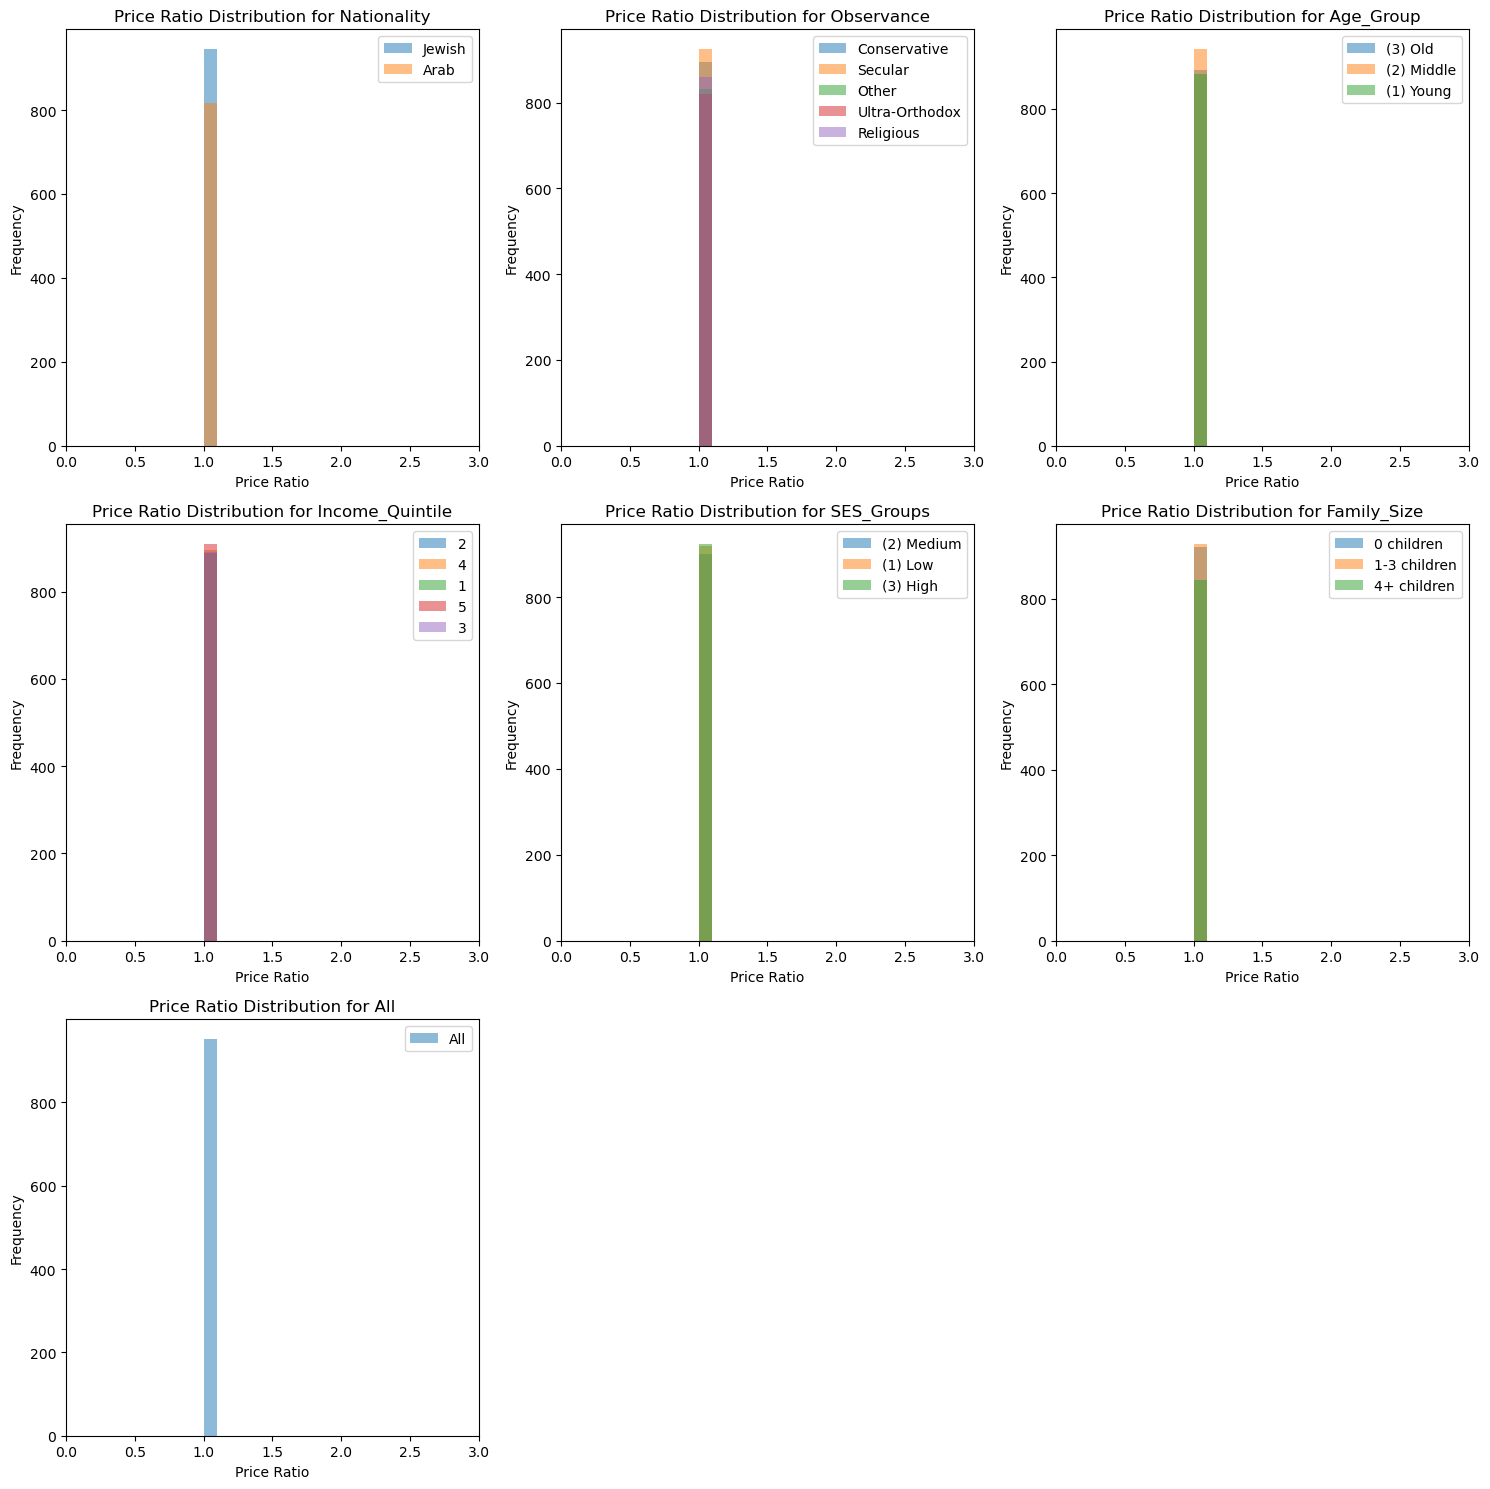

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Define the groups to plot
groups_to_plot = list(price_indexes[comparison_year].keys())

# Calculate the number of rows needed
ncols = 3
nrows = (len(groups_to_plot) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
axes = axes.flatten()

# Plot each group
for ax, group in zip(axes, groups_to_plot):
    subgroups = price_indexes[comparison_year][group].keys()
    for subgroup in subgroups:
        price_ratios = price_indexes[comparison_year][group][subgroup]['price_ratio']
        ax.hist(price_ratios, bins=np.arange(0, 5.1, 0.1), alpha=0.5, label=subgroup)
    ax.set_title(f'Price Ratio Distribution for {group}')
    ax.set_xlabel('Price Ratio')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 3)
    ax.legend()

# Remove any unused subplots
for ax in axes[len(groups_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## Laspeyres Group Indexes

In [224]:
yearly_indexes = {}
for group in Groups[base_year].columns[1:]:
    # Initialize dataframe
    df = pd.DataFrame({'year': years})
    for subgroup in Groups[base_year][group].unique():
        df[subgroup] = None 
    for year in years:
        for subgroup in Groups[year][group].unique():
            if subgroup in price_indexes[year][group]:
                df.loc[df['year'] == year, subgroup] = (price_indexes[year][group][subgroup]['price_ratio'] * price_indexes[year][group][subgroup]['weight']).sum() * 100
    yearly_indexes[group] = df

# Add 'All' group
df_all = pd.DataFrame({'year': years})
df_all['all'] = None
for year in years:
    if 'All' in price_indexes[year] and 'All' in price_indexes[year]['All']:
        df_all.loc[df_all['year'] == year, 'all'] = (price_indexes[year]['All']['All']['price_ratio'] * price_indexes[year]['All']['All']['weight']).sum() * 100
yearly_indexes['All'] = df_all

## Merging to Secondary Categories

In [225]:
def merge_to_secondary(df):
    grouped = df.copy()
    grouped['prodcode_secondary'] = grouped['prodcode'].astype(str).str[:3]
    grouped = grouped.groupby('prodcode_secondary', group_keys=False).apply(
        lambda x: pd.Series({
            'price_ratio': np.average(x['price_ratio'], weights=x['weight']) if x['weight'].sum() > 0 else np.nan,
            'total_weight': x['weight'].sum()
        }),
        include_groups=False 
    ).reset_index()
    grouped.rename(columns={'prodcode_secondary': 'prodcode'}, inplace=True)
    grouped.rename(columns={'total_weight': 'weight'}, inplace=True)
    return grouped

In [226]:
# Merge to secondary categories
price_indexes_secondary = {}
for year in years:
    price_indexes_secondary[year] = {}
    for group in price_indexes[year].keys():
        price_indexes_secondary[year][group] = {}
        for subgroup in price_indexes[year][group].keys():
            price_indexes_secondary[year][group][subgroup] = merge_to_secondary(price_indexes[year][group][subgroup])

In [227]:
# Load prodcode dictionary
prodcode_dict_df = pd.read_csv(prodcode_dict_pathname)
prodcode_dict_df['prodcode']=prodcode_dict_df['prodcode'].astype(str)

In [228]:
# Add description to secondary categories
for year in price_indexes_secondary:
    for group in price_indexes_secondary[year]:
        for subgroup in price_indexes_secondary[year][group]:
            price_indexes_secondary[year][group][subgroup] = price_indexes_secondary[year][group][subgroup].merge(prodcode_dict_df, on='prodcode', how='left')

## Merge to Primary Categories

In [229]:
def merge_to_primary(df):
    grouped = df.copy()
    grouped['prodcode_primary'] = grouped['prodcode'].astype(str).str[:2]
    grouped = grouped.groupby('prodcode_primary', group_keys=False).apply(
        lambda x: pd.Series({
            'price_ratio': np.average(x['price_ratio'], weights=x['weight']) if x['weight'].sum() > 0 else np.nan,
            'total_weight': x['weight'].sum()
        }),
        include_groups=False 
    ).reset_index()
    grouped.rename(columns={'prodcode_primary': 'prodcode'}, inplace=True)
    grouped.rename(columns={'total_weight': 'weight'}, inplace=True)
    return grouped

In [230]:
# Merge to secondary categories
price_indexes_primary = {}
for year in years:
    price_indexes_primary[year] = {}
    for group in price_indexes[year].keys():
        price_indexes_primary[year][group] = {}
        for subgroup in price_indexes[year][group].keys():
            price_indexes_primary[year][group][subgroup] = merge_to_primary(price_indexes_secondary[year][group][subgroup])

In [231]:
# Add description to secondary categories
for year in price_indexes_primary:
    for group in price_indexes_primary[year]:
        for subgroup in price_indexes_primary[year][group]:
            price_indexes_primary[year][group][subgroup] = price_indexes_primary[year][group][subgroup].merge(prodcode_dict_df, on='prodcode', how='left')

# Plots

## Compare to CPI

In [232]:
# Load CPI data
cpi_data_df = pd.read_csv(cpi_data_pathname)
cpi_data_df = cpi_data_df[cpi_data_df['year'].isin(years)]
columns_to_drop = [str(i) for i in range(1, 12)]
cpi_data_df.drop(columns=columns_to_drop, axis=1, inplace=True)
cpi_data_df.rename(columns={'12': 'price_index'}, inplace=True)
cpi_data_df['prodcode'] = cpi_data_df['prodcode'].astype(float).astype(int)

In [233]:
# Initialize an empty list to store dataframes for each year
cpi_comparison_list = []

# Loop through each year and extract the data for group 'all'
for year in years:
    if 'All' in price_indexes_primary[year] and 'All' in price_indexes_primary[year]['All']:
        df = price_indexes_primary[year]['All']['All'].copy()
        df['year'] = year
        cpi_comparison_list.append(df)
        df['price_ratio'] *= 100

# Concatenate all dataframes into one
cpi_comparison = pd.concat(cpi_comparison_list, ignore_index=True)

# Ensure 'prodcode' columns are of the same type (string) in both dataframes
cpi_comparison['prodcode'] = cpi_comparison['prodcode'].astype(str)
cpi_data_df['prodcode'] = cpi_data_df['prodcode'].astype(str)

# Merge cpi_data_df with cpi_comparison on 'year' and 'prodcode'
cpi_comparison = cpi_comparison.merge(cpi_data_df[['year', 'prodcode', 'price_index']], on=['year', 'prodcode'], how='left')

# Rename the 'price_index' column to 'price_ratio_cpi'
cpi_comparison.rename(columns={'price_index': 'price_ratio_cpi'}, inplace=True)
# Reorder columns to place 'price_ratio_cpi' to the right of 'price_ratio'
cols = list(cpi_comparison.columns)
price_ratio_index = cols.index('price_ratio')
cols.insert(price_ratio_index + 1, cols.pop(cols.index('price_ratio_cpi')))
cpi_comparison = cpi_comparison[cols]

/var/folders/m9/b19pphns6hqc2k27c3qtngn40000gn/T/ipykernel_75491/2370450921.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_index_comparison = cpi_comparison.groupby('year', group_keys=False).apply(


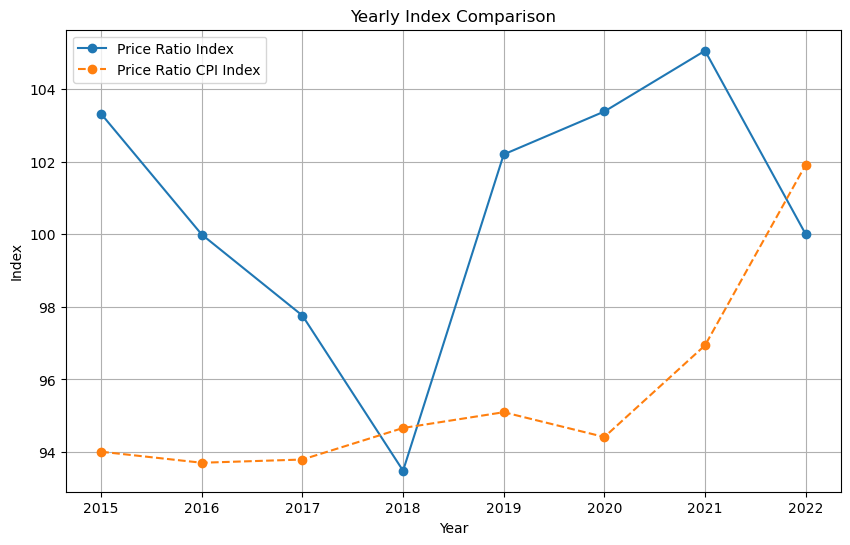

In [ ]:
# Calculate the weighted sum for price_ratio and price_ratio_cpi
yearly_index_comparison = cpi_comparison.groupby('year', group_keys=False).apply(
    lambda x: pd.Series({
        'price_ratio_index': (x['price_ratio'] * x['weight']).sum(),
        'price_ratio_cpi_index': (x['price_ratio_cpi'] * x['weight']).sum()
    })
).reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(yearly_index_comparison['year'], yearly_index_comparison['price_ratio_index'], label='Price Index Index', marker='o')
plt.plot(yearly_index_comparison['year'], yearly_index_comparison['price_ratio_cpi_index'], label='Price Index CPI Index', marker='o', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('Yearly Index Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Price Index Over Time

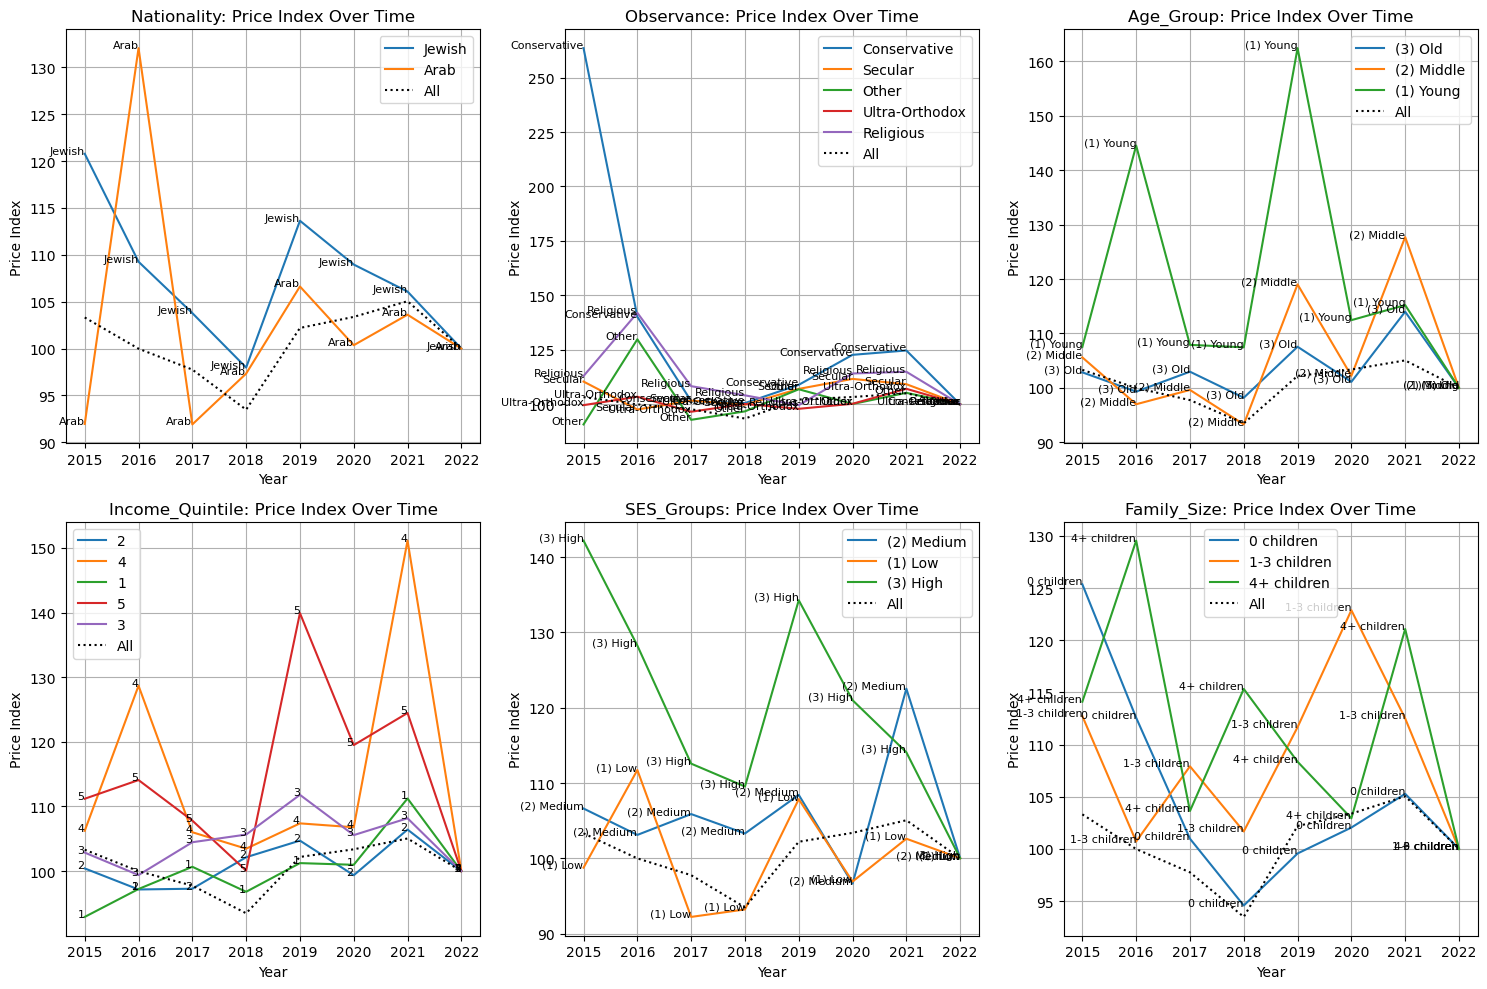

In [235]:
def price_index_over_time(yearly_indexes):
    import matplotlib.pyplot as plt

    # Calculate the number of groups
    n_groups = len(yearly_indexes) - 1
    ncols = 3
    nrows = (n_groups + ncols - 1) // ncols

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.flatten()

    # Plot each group
    for ax, (group, yearly_indexes_group) in zip(axes, yearly_indexes.items()):
        years = yearly_indexes_group['year']
        indexes = yearly_indexes_group.drop(columns=['year'])
        for subgroup in indexes.columns:
            if group == 'All' and subgroup == 'all':
                continue
            ax.plot(years, indexes[subgroup], label=subgroup)
            for i, year in enumerate(years):
                ax.text(year, indexes[subgroup].iloc[i], subgroup, fontsize=8, ha='right')
        
        # Add dotted line for 'All' group
        if 'all' in yearly_indexes['All'].columns:
            ax.plot(yearly_indexes['All']['year'], yearly_indexes['All']['all'], label='All', linestyle='dotted', color='black')
        
        ax.set_title(f"{group}: Price Index Over Time")
        ax.set_xlabel('Year')
        ax.set_ylabel('Price Index')
        ax.legend()
        ax.grid(True)

    # Remove any unused subplots
    for ax in axes[len(yearly_indexes):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

price_index_over_time(yearly_indexes)


## Top Weights

In [236]:
from IPython.display import display, HTML

def display_top_weights(weights, top_n=10):
    for group in weights.keys():
        if group == 'All':
            continue

        subgroups = weights[group].keys()
        try:
            subgroups = sorted(subgroups, key=int)
        except ValueError:
            subgroups = weights[group].keys()

        for subgroup in subgroups:
            # Sort by the weight in descending order
            sorted_weights_df = weights[group][subgroup].sort_values(by='weight', ascending=False)

            # Select the top n weights
            top_n_weights_df = sorted_weights_df.head(top_n)

            # Display the HTML table
            display(HTML(f"<h3>{group} - {subgroup}</h3>"))
            display(HTML(top_n_weights_df.to_html(index=False)))

display_top_weights(price_indexes_secondary[end_year], top_n)

prodcode,price_ratio,weight,description
323,1.0,0.187722,Housing Services Consumption
383,1.0,0.115522,Vehicle Expenses
371,1.0,0.062902,Education Services
322,1.0,0.062179,Monthly Rent
382,1.0,0.042920,Travel Abroad
336,1.0,0.028381,Municipal Taxes
332,1.0,0.026324,Electricity Gas And Fuel For Home
308,1.0,0.026065,Meals Outside Home
302,1.0,0.022853,Meat And Poultry
309,1.0,0.022409,Various Food Products


prodcode,price_ratio,weight,description
383,1.0,0.130911,Vehicle Expenses
323,1.0,0.120862,Housing Services Consumption
302,1.0,0.069203,Meat And Poultry
371,1.0,0.040681,Education Services
309,1.0,0.039002,Various Food Products
332,1.0,0.037695,Electricity Gas And Fuel For Home
382,1.0,0.033873,Travel Abroad
300,1.0,0.026362,Bread Grains and Pastries
308,1.0,0.025640,Meals Outside Home
364,1.0,0.024835,Other Health Expenses


prodcode,price_ratio,weight,description
323,1.0,0.202591,Housing Services Consumption
383,1.0,0.126981,Vehicle Expenses
322,1.0,0.049960,Monthly Rent
371,1.0,0.048459,Education Services
382,1.0,0.041448,Travel Abroad
332,1.0,0.028192,Electricity Gas And Fuel For Home
336,1.0,0.027968,Municipal Taxes
302,1.0,0.024770,Meat And Poultry
308,1.0,0.022847,Meals Outside Home
309,1.0,0.022762,Various Food Products


prodcode,price_ratio,weight,description
323,1.0,0.180194,Housing Services Consumption
383,1.0,0.125951,Vehicle Expenses
322,1.0,0.067803,Monthly Rent
371,1.0,0.058293,Education Services
382,1.0,0.056158,Travel Abroad
308,1.0,0.035577,Meals Outside Home
336,1.0,0.029603,Municipal Taxes
332,1.0,0.023475,Electricity Gas And Fuel For Home
304,1.0,0.021443,Dairy Products And Eggs
302,1.0,0.020572,Meat And Poultry


prodcode,price_ratio,weight,description
383,1.0,0.132219,Vehicle Expenses
323,1.0,0.123271,Housing Services Consumption
302,1.0,0.066918,Meat And Poultry
371,1.0,0.041048,Education Services
309,1.0,0.038555,Various Food Products
332,1.0,0.037152,Electricity Gas And Fuel For Home
382,1.0,0.034056,Travel Abroad
300,1.0,0.025825,Bread Grains and Pastries
308,1.0,0.025371,Meals Outside Home
364,1.0,0.024130,Other Health Expenses


prodcode,price_ratio,weight,description
323,1.0,0.188299,Housing Services Consumption
371,1.0,0.103318,Education Services
322,1.0,0.076549,Monthly Rent
383,1.0,0.058165,Vehicle Expenses
397,1.0,0.035268,Organization Fees And Donations
309,1.0,0.031596,Various Food Products
332,1.0,0.030978,Electricity Gas And Fuel For Home
300,1.0,0.029392,Bread Grains and Pastries
302,1.0,0.026925,Meat And Poultry
373,1.0,0.024488,Culture Sports And Entertainment Events


prodcode,price_ratio,weight,description
323,1.0,0.186777,Housing Services Consumption
383,1.0,0.105375,Vehicle Expenses
371,1.0,0.070950,Education Services
322,1.0,0.053654,Monthly Rent
373,1.0,0.046140,Culture Sports And Entertainment Events
336,1.0,0.029708,Municipal Taxes
332,1.0,0.028881,Electricity Gas And Fuel For Home
382,1.0,0.027668,Travel Abroad
309,1.0,0.026504,Various Food Products
302,1.0,0.024404,Meat And Poultry


prodcode,price_ratio,weight,description
323,1.0,0.245729,Housing Services Consumption
383,1.0,0.098856,Vehicle Expenses
382,1.0,0.043889,Travel Abroad
322,1.0,0.034225,Monthly Rent
302,1.0,0.030935,Meat And Poultry
336,1.0,0.029960,Municipal Taxes
332,1.0,0.029725,Electricity Gas And Fuel For Home
334,1.0,0.029119,Household Help
364,1.0,0.025973,Other Health Expenses
362,1.0,0.025443,Dental Care


prodcode,price_ratio,weight,description
323,1.0,0.158280,Housing Services Consumption
383,1.0,0.125903,Vehicle Expenses
371,1.0,0.077219,Education Services
322,1.0,0.058404,Monthly Rent
382,1.0,0.040392,Travel Abroad
302,1.0,0.028176,Meat And Poultry
308,1.0,0.027413,Meals Outside Home
332,1.0,0.026915,Electricity Gas And Fuel For Home
336,1.0,0.026054,Municipal Taxes
309,1.0,0.025490,Various Food Products


prodcode,price_ratio,weight,description
323,1.0,0.144735,Housing Services Consumption
383,1.0,0.115540,Vehicle Expenses
322,1.0,0.085731,Monthly Rent
371,1.0,0.060962,Education Services
382,1.0,0.043309,Travel Abroad
302,1.0,0.030670,Meat And Poultry
332,1.0,0.028800,Electricity Gas And Fuel For Home
308,1.0,0.027010,Meals Outside Home
309,1.0,0.026749,Various Food Products
336,1.0,0.024833,Municipal Taxes


prodcode,price_ratio,weight,description
323,1.0,0.125406,Housing Services Consumption
322,1.0,0.097904,Monthly Rent
383,1.0,0.083524,Vehicle Expenses
371,1.0,0.082942,Education Services
302,1.0,0.043897,Meat And Poultry
332,1.0,0.034375,Electricity Gas And Fuel For Home
309,1.0,0.033348,Various Food Products
300,1.0,0.031964,Bread Grains and Pastries
304,1.0,0.024170,Dairy Products And Eggs
336,1.0,0.020515,Municipal Taxes


prodcode,price_ratio,weight,description
323,1.0,0.163430,Housing Services Consumption
383,1.0,0.105324,Vehicle Expenses
322,1.0,0.070818,Monthly Rent
371,1.0,0.063788,Education Services
302,1.0,0.036360,Meat And Poultry
332,1.0,0.032840,Electricity Gas And Fuel For Home
309,1.0,0.030849,Various Food Products
300,1.0,0.027391,Bread Grains and Pastries
336,1.0,0.024053,Municipal Taxes
304,1.0,0.023024,Dairy Products And Eggs


prodcode,price_ratio,weight,description
323,1.0,0.178467,Housing Services Consumption
383,1.0,0.119083,Vehicle Expenses
371,1.0,0.066167,Education Services
322,1.0,0.060487,Monthly Rent
382,1.0,0.035088,Travel Abroad
302,1.0,0.031862,Meat And Poultry
332,1.0,0.029277,Electricity Gas And Fuel For Home
336,1.0,0.027685,Municipal Taxes
309,1.0,0.026228,Various Food Products
308,1.0,0.024675,Meals Outside Home


prodcode,price_ratio,weight,description
323,1.0,0.194534,Housing Services Consumption
383,1.0,0.136853,Vehicle Expenses
371,1.0,0.059146,Education Services
382,1.0,0.045067,Travel Abroad
322,1.0,0.040671,Monthly Rent
336,1.0,0.029306,Municipal Taxes
308,1.0,0.028052,Meals Outside Home
332,1.0,0.025981,Electricity Gas And Fuel For Home
373,1.0,0.025585,Culture Sports And Entertainment Events
302,1.0,0.025329,Meat And Poultry


prodcode,price_ratio,weight,description
323,1.0,0.201443,Housing Services Consumption
383,1.0,0.125930,Vehicle Expenses
382,1.0,0.067804,Travel Abroad
371,1.0,0.042506,Education Services
322,1.0,0.035665,Monthly Rent
308,1.0,0.033918,Meals Outside Home
336,1.0,0.029265,Municipal Taxes
332,1.0,0.022365,Electricity Gas And Fuel For Home
334,1.0,0.021243,Household Help
373,1.0,0.020035,Culture Sports And Entertainment Events


prodcode,price_ratio,weight,description
323,1.0,0.179979,Housing Services Consumption
383,1.0,0.126246,Vehicle Expenses
371,1.0,0.054945,Education Services
322,1.0,0.053576,Monthly Rent
382,1.0,0.037565,Travel Abroad
332,1.0,0.028872,Electricity Gas And Fuel For Home
302,1.0,0.027871,Meat And Poultry
336,1.0,0.026874,Municipal Taxes
309,1.0,0.025802,Various Food Products
300,1.0,0.023809,Bread Grains and Pastries


prodcode,price_ratio,weight,description
323,1.0,0.160041,Housing Services Consumption
383,1.0,0.101388,Vehicle Expenses
371,1.0,0.063235,Education Services
322,1.0,0.048468,Monthly Rent
302,1.0,0.043318,Meat And Poultry
309,1.0,0.032782,Various Food Products
332,1.0,0.032565,Electricity Gas And Fuel For Home
300,1.0,0.026779,Bread Grains and Pastries
382,1.0,0.024654,Travel Abroad
373,1.0,0.022766,Culture Sports And Entertainment Events


prodcode,price_ratio,weight,description
323,1.0,0.191572,Housing Services Consumption
383,1.0,0.125770,Vehicle Expenses
322,1.0,0.062755,Monthly Rent
371,1.0,0.059558,Education Services
382,1.0,0.056111,Travel Abroad
308,1.0,0.031708,Meals Outside Home
336,1.0,0.030219,Municipal Taxes
332,1.0,0.023983,Electricity Gas And Fuel For Home
302,1.0,0.019400,Meat And Poultry
304,1.0,0.019121,Dairy Products And Eggs


prodcode,price_ratio,weight,description
323,1.0,0.211939,Housing Services Consumption
383,1.0,0.110245,Vehicle Expenses
322,1.0,0.053887,Monthly Rent
382,1.0,0.045723,Travel Abroad
302,1.0,0.030831,Meat And Poultry
332,1.0,0.028992,Electricity Gas And Fuel For Home
336,1.0,0.028841,Municipal Taxes
308,1.0,0.026172,Meals Outside Home
371,1.0,0.023060,Education Services
309,1.0,0.023044,Various Food Products


prodcode,price_ratio,weight,description
323,1.0,0.144483,Housing Services Consumption
383,1.0,0.131998,Vehicle Expenses
371,1.0,0.084170,Education Services
322,1.0,0.061465,Monthly Rent
382,1.0,0.043042,Travel Abroad
308,1.0,0.028525,Meals Outside Home
302,1.0,0.027480,Meat And Poultry
332,1.0,0.026406,Electricity Gas And Fuel For Home
336,1.0,0.025599,Municipal Taxes
309,1.0,0.024875,Various Food Products


prodcode,price_ratio,weight,description
323,1.0,0.166513,Housing Services Consumption
371,1.0,0.124776,Education Services
383,1.0,0.093581,Vehicle Expenses
322,1.0,0.044220,Monthly Rent
300,1.0,0.031608,Bread Grains and Pastries
309,1.0,0.031098,Various Food Products
373,1.0,0.030303,Culture Sports And Entertainment Events
302,1.0,0.028992,Meat And Poultry
332,1.0,0.028863,Electricity Gas And Fuel For Home
336,1.0,0.023309,Municipal Taxes


## Top Contributors to Index Change

In [237]:
from IPython.display import display, HTML

def top_contributors_to_index_change(price_indexes, top_n=5, last_year=None):
    if last_year is None:
        last_year = max(price_indexes.keys())

    for group in price_indexes[last_year]:
        for subgroup in price_indexes[last_year][group]:
            # Calculate the contribution to the index change
            price_indexes[last_year][group][subgroup]['contribution'] = price_indexes[last_year][group][subgroup]['weight'] * price_indexes[last_year][group][subgroup]['price_ratio']

            # Sort by the contribution in descending order
            sorted_contributors = price_indexes[last_year][group][subgroup].sort_values(by='contribution', ascending=False)

            # Select the top n contributors
            top_contributors = sorted_contributors.head(top_n)

            # Display the results
            display(HTML(f"<h3>Top {top_n} Contributors to Index Change for {group} - {subgroup} in {last_year}</h3>"))
            display(HTML(top_contributors.to_html(index=False)))

top_contributors_to_index_change(price_indexes_secondary, top_n, last_year=end_year)

prodcode,price_ratio,weight,description,contribution
323,1.0,0.187722,Housing Services Consumption,0.187722
383,1.0,0.115522,Vehicle Expenses,0.115522
371,1.0,0.062902,Education Services,0.062902
322,1.0,0.062179,Monthly Rent,0.062179
382,1.0,0.042920,Travel Abroad,0.042920
336,1.0,0.028381,Municipal Taxes,0.028381
332,1.0,0.026324,Electricity Gas And Fuel For Home,0.026324
308,1.0,0.026065,Meals Outside Home,0.026065
302,1.0,0.022853,Meat And Poultry,0.022853
309,1.0,0.022409,Various Food Products,0.022409


prodcode,price_ratio,weight,description,contribution
383,1.0,0.130911,Vehicle Expenses,0.130911
323,1.0,0.120862,Housing Services Consumption,0.120862
302,1.0,0.069203,Meat And Poultry,0.069203
371,1.0,0.040681,Education Services,0.040681
309,1.0,0.039002,Various Food Products,0.039002
332,1.0,0.037695,Electricity Gas And Fuel For Home,0.037695
382,1.0,0.033873,Travel Abroad,0.033873
300,1.0,0.026362,Bread Grains and Pastries,0.026362
308,1.0,0.025640,Meals Outside Home,0.025640
364,1.0,0.024835,Other Health Expenses,0.024835


prodcode,price_ratio,weight,description,contribution
323,1.0,0.202591,Housing Services Consumption,0.202591
383,1.0,0.126981,Vehicle Expenses,0.126981
322,1.0,0.049960,Monthly Rent,0.049960
371,1.0,0.048459,Education Services,0.048459
382,1.0,0.041448,Travel Abroad,0.041448
332,1.0,0.028192,Electricity Gas And Fuel For Home,0.028192
336,1.0,0.027968,Municipal Taxes,0.027968
302,1.0,0.024770,Meat And Poultry,0.024770
308,1.0,0.022847,Meals Outside Home,0.022847
309,1.0,0.022762,Various Food Products,0.022762


prodcode,price_ratio,weight,description,contribution
323,1.0,0.180194,Housing Services Consumption,0.180194
383,1.0,0.125951,Vehicle Expenses,0.125951
322,1.0,0.067803,Monthly Rent,0.067803
371,1.0,0.058293,Education Services,0.058293
382,1.0,0.056158,Travel Abroad,0.056158
308,1.0,0.035577,Meals Outside Home,0.035577
336,1.0,0.029603,Municipal Taxes,0.029603
332,1.0,0.023475,Electricity Gas And Fuel For Home,0.023475
304,1.0,0.021443,Dairy Products And Eggs,0.021443
302,1.0,0.020572,Meat And Poultry,0.020572


prodcode,price_ratio,weight,description,contribution
383,1.0,0.132219,Vehicle Expenses,0.132219
323,1.0,0.123271,Housing Services Consumption,0.123271
302,1.0,0.066918,Meat And Poultry,0.066918
371,1.0,0.041048,Education Services,0.041048
309,1.0,0.038555,Various Food Products,0.038555
332,1.0,0.037152,Electricity Gas And Fuel For Home,0.037152
382,1.0,0.034056,Travel Abroad,0.034056
300,1.0,0.025825,Bread Grains and Pastries,0.025825
308,1.0,0.025371,Meals Outside Home,0.025371
364,1.0,0.024130,Other Health Expenses,0.024130


prodcode,price_ratio,weight,description,contribution
323,1.0,0.188299,Housing Services Consumption,0.188299
371,1.0,0.103318,Education Services,0.103318
322,1.0,0.076549,Monthly Rent,0.076549
383,1.0,0.058165,Vehicle Expenses,0.058165
397,1.0,0.035268,Organization Fees And Donations,0.035268
309,1.0,0.031596,Various Food Products,0.031596
332,1.0,0.030978,Electricity Gas And Fuel For Home,0.030978
300,1.0,0.029392,Bread Grains and Pastries,0.029392
302,1.0,0.026925,Meat And Poultry,0.026925
373,1.0,0.024488,Culture Sports And Entertainment Events,0.024488


prodcode,price_ratio,weight,description,contribution
323,1.0,0.186777,Housing Services Consumption,0.186777
383,1.0,0.105375,Vehicle Expenses,0.105375
371,1.0,0.070950,Education Services,0.070950
322,1.0,0.053654,Monthly Rent,0.053654
373,1.0,0.046140,Culture Sports And Entertainment Events,0.046140
336,1.0,0.029708,Municipal Taxes,0.029708
332,1.0,0.028881,Electricity Gas And Fuel For Home,0.028881
382,1.0,0.027668,Travel Abroad,0.027668
309,1.0,0.026504,Various Food Products,0.026504
302,1.0,0.024404,Meat And Poultry,0.024404


prodcode,price_ratio,weight,description,contribution
323,1.0,0.245729,Housing Services Consumption,0.245729
383,1.0,0.098856,Vehicle Expenses,0.098856
382,1.0,0.043889,Travel Abroad,0.043889
322,1.0,0.034225,Monthly Rent,0.034225
302,1.0,0.030935,Meat And Poultry,0.030935
336,1.0,0.029960,Municipal Taxes,0.029960
332,1.0,0.029725,Electricity Gas And Fuel For Home,0.029725
334,1.0,0.029119,Household Help,0.029119
364,1.0,0.025973,Other Health Expenses,0.025973
362,1.0,0.025443,Dental Care,0.025443


prodcode,price_ratio,weight,description,contribution
323,1.0,0.158280,Housing Services Consumption,0.158280
383,1.0,0.125903,Vehicle Expenses,0.125903
371,1.0,0.077219,Education Services,0.077219
322,1.0,0.058404,Monthly Rent,0.058404
382,1.0,0.040392,Travel Abroad,0.040392
302,1.0,0.028176,Meat And Poultry,0.028176
308,1.0,0.027413,Meals Outside Home,0.027413
332,1.0,0.026915,Electricity Gas And Fuel For Home,0.026915
336,1.0,0.026054,Municipal Taxes,0.026054
309,1.0,0.025490,Various Food Products,0.025490


prodcode,price_ratio,weight,description,contribution
323,1.0,0.144735,Housing Services Consumption,0.144735
383,1.0,0.115540,Vehicle Expenses,0.115540
322,1.0,0.085731,Monthly Rent,0.085731
371,1.0,0.060962,Education Services,0.060962
382,1.0,0.043309,Travel Abroad,0.043309
302,1.0,0.030670,Meat And Poultry,0.030670
332,1.0,0.028800,Electricity Gas And Fuel For Home,0.028800
308,1.0,0.027010,Meals Outside Home,0.027010
309,1.0,0.026749,Various Food Products,0.026749
336,1.0,0.024833,Municipal Taxes,0.024833


prodcode,price_ratio,weight,description,contribution
323,1.0,0.163430,Housing Services Consumption,0.163430
383,1.0,0.105324,Vehicle Expenses,0.105324
322,1.0,0.070818,Monthly Rent,0.070818
371,1.0,0.063788,Education Services,0.063788
302,1.0,0.036360,Meat And Poultry,0.036360
332,1.0,0.032840,Electricity Gas And Fuel For Home,0.032840
309,1.0,0.030849,Various Food Products,0.030849
300,1.0,0.027391,Bread Grains and Pastries,0.027391
336,1.0,0.024053,Municipal Taxes,0.024053
304,1.0,0.023024,Dairy Products And Eggs,0.023024


prodcode,price_ratio,weight,description,contribution
323,1.0,0.194534,Housing Services Consumption,0.194534
383,1.0,0.136853,Vehicle Expenses,0.136853
371,1.0,0.059146,Education Services,0.059146
382,1.0,0.045067,Travel Abroad,0.045067
322,1.0,0.040671,Monthly Rent,0.040671
336,1.0,0.029306,Municipal Taxes,0.029306
308,1.0,0.028052,Meals Outside Home,0.028052
332,1.0,0.025981,Electricity Gas And Fuel For Home,0.025981
373,1.0,0.025585,Culture Sports And Entertainment Events,0.025585
302,1.0,0.025329,Meat And Poultry,0.025329


prodcode,price_ratio,weight,description,contribution
323,1.0,0.125406,Housing Services Consumption,0.125406
322,1.0,0.097904,Monthly Rent,0.097904
383,1.0,0.083524,Vehicle Expenses,0.083524
371,1.0,0.082942,Education Services,0.082942
302,1.0,0.043897,Meat And Poultry,0.043897
332,1.0,0.034375,Electricity Gas And Fuel For Home,0.034375
309,1.0,0.033348,Various Food Products,0.033348
300,1.0,0.031964,Bread Grains and Pastries,0.031964
304,1.0,0.024170,Dairy Products And Eggs,0.024170
336,1.0,0.020515,Municipal Taxes,0.020515


prodcode,price_ratio,weight,description,contribution
323,1.0,0.201443,Housing Services Consumption,0.201443
383,1.0,0.125930,Vehicle Expenses,0.125930
382,1.0,0.067804,Travel Abroad,0.067804
371,1.0,0.042506,Education Services,0.042506
322,1.0,0.035665,Monthly Rent,0.035665
308,1.0,0.033918,Meals Outside Home,0.033918
336,1.0,0.029265,Municipal Taxes,0.029265
332,1.0,0.022365,Electricity Gas And Fuel For Home,0.022365
334,1.0,0.021243,Household Help,0.021243
373,1.0,0.020035,Culture Sports And Entertainment Events,0.020035


prodcode,price_ratio,weight,description,contribution
323,1.0,0.178467,Housing Services Consumption,0.178467
383,1.0,0.119083,Vehicle Expenses,0.119083
371,1.0,0.066167,Education Services,0.066167
322,1.0,0.060487,Monthly Rent,0.060487
382,1.0,0.035088,Travel Abroad,0.035088
302,1.0,0.031862,Meat And Poultry,0.031862
332,1.0,0.029277,Electricity Gas And Fuel For Home,0.029277
336,1.0,0.027685,Municipal Taxes,0.027685
309,1.0,0.026228,Various Food Products,0.026228
308,1.0,0.024675,Meals Outside Home,0.024675


prodcode,price_ratio,weight,description,contribution
323,1.0,0.179979,Housing Services Consumption,0.179979
383,1.0,0.126246,Vehicle Expenses,0.126246
371,1.0,0.054945,Education Services,0.054945
322,1.0,0.053576,Monthly Rent,0.053576
382,1.0,0.037565,Travel Abroad,0.037565
332,1.0,0.028872,Electricity Gas And Fuel For Home,0.028872
302,1.0,0.027871,Meat And Poultry,0.027871
336,1.0,0.026874,Municipal Taxes,0.026874
309,1.0,0.025802,Various Food Products,0.025802
300,1.0,0.023809,Bread Grains and Pastries,0.023809


prodcode,price_ratio,weight,description,contribution
323,1.0,0.160041,Housing Services Consumption,0.160041
383,1.0,0.101388,Vehicle Expenses,0.101388
371,1.0,0.063235,Education Services,0.063235
322,1.0,0.048468,Monthly Rent,0.048468
302,1.0,0.043318,Meat And Poultry,0.043318
309,1.0,0.032782,Various Food Products,0.032782
332,1.0,0.032565,Electricity Gas And Fuel For Home,0.032565
300,1.0,0.026779,Bread Grains and Pastries,0.026779
382,1.0,0.024654,Travel Abroad,0.024654
373,1.0,0.022766,Culture Sports And Entertainment Events,0.022766


prodcode,price_ratio,weight,description,contribution
323,1.0,0.191572,Housing Services Consumption,0.191572
383,1.0,0.125770,Vehicle Expenses,0.125770
322,1.0,0.062755,Monthly Rent,0.062755
371,1.0,0.059558,Education Services,0.059558
382,1.0,0.056111,Travel Abroad,0.056111
308,1.0,0.031708,Meals Outside Home,0.031708
336,1.0,0.030219,Municipal Taxes,0.030219
332,1.0,0.023983,Electricity Gas And Fuel For Home,0.023983
302,1.0,0.019400,Meat And Poultry,0.019400
304,1.0,0.019121,Dairy Products And Eggs,0.019121


prodcode,price_ratio,weight,description,contribution
323,1.0,0.211939,Housing Services Consumption,0.211939
383,1.0,0.110245,Vehicle Expenses,0.110245
322,1.0,0.053887,Monthly Rent,0.053887
382,1.0,0.045723,Travel Abroad,0.045723
302,1.0,0.030831,Meat And Poultry,0.030831
332,1.0,0.028992,Electricity Gas And Fuel For Home,0.028992
336,1.0,0.028841,Municipal Taxes,0.028841
308,1.0,0.026172,Meals Outside Home,0.026172
371,1.0,0.023060,Education Services,0.023060
309,1.0,0.023044,Various Food Products,0.023044


prodcode,price_ratio,weight,description,contribution
323,1.0,0.144483,Housing Services Consumption,0.144483
383,1.0,0.131998,Vehicle Expenses,0.131998
371,1.0,0.084170,Education Services,0.084170
322,1.0,0.061465,Monthly Rent,0.061465
382,1.0,0.043042,Travel Abroad,0.043042
308,1.0,0.028525,Meals Outside Home,0.028525
302,1.0,0.027480,Meat And Poultry,0.027480
332,1.0,0.026406,Electricity Gas And Fuel For Home,0.026406
336,1.0,0.025599,Municipal Taxes,0.025599
309,1.0,0.024875,Various Food Products,0.024875


prodcode,price_ratio,weight,description,contribution
323,1.0,0.166513,Housing Services Consumption,0.166513
371,1.0,0.124776,Education Services,0.124776
383,1.0,0.093581,Vehicle Expenses,0.093581
322,1.0,0.044220,Monthly Rent,0.044220
300,1.0,0.031608,Bread Grains and Pastries,0.031608
309,1.0,0.031098,Various Food Products,0.031098
373,1.0,0.030303,Culture Sports And Entertainment Events,0.030303
302,1.0,0.028992,Meat And Poultry,0.028992
332,1.0,0.028863,Electricity Gas And Fuel For Home,0.028863
336,1.0,0.023309,Municipal Taxes,0.023309


prodcode,price_ratio,weight,description,contribution
323,1.0,0.176920,Housing Services Consumption,0.176920
383,1.0,0.118308,Vehicle Expenses,0.118308
371,1.0,0.059418,Education Services,0.059418
322,1.0,0.057739,Monthly Rent,0.057739
382,1.0,0.042298,Travel Abroad,0.042298
302,1.0,0.029333,Meat And Poultry,0.029333
332,1.0,0.027734,Electricity Gas And Fuel For Home,0.027734
336,1.0,0.026742,Municipal Taxes,0.026742
308,1.0,0.026142,Meals Outside Home,0.026142
309,1.0,0.024549,Various Food Products,0.024549


## Top Weight Differences

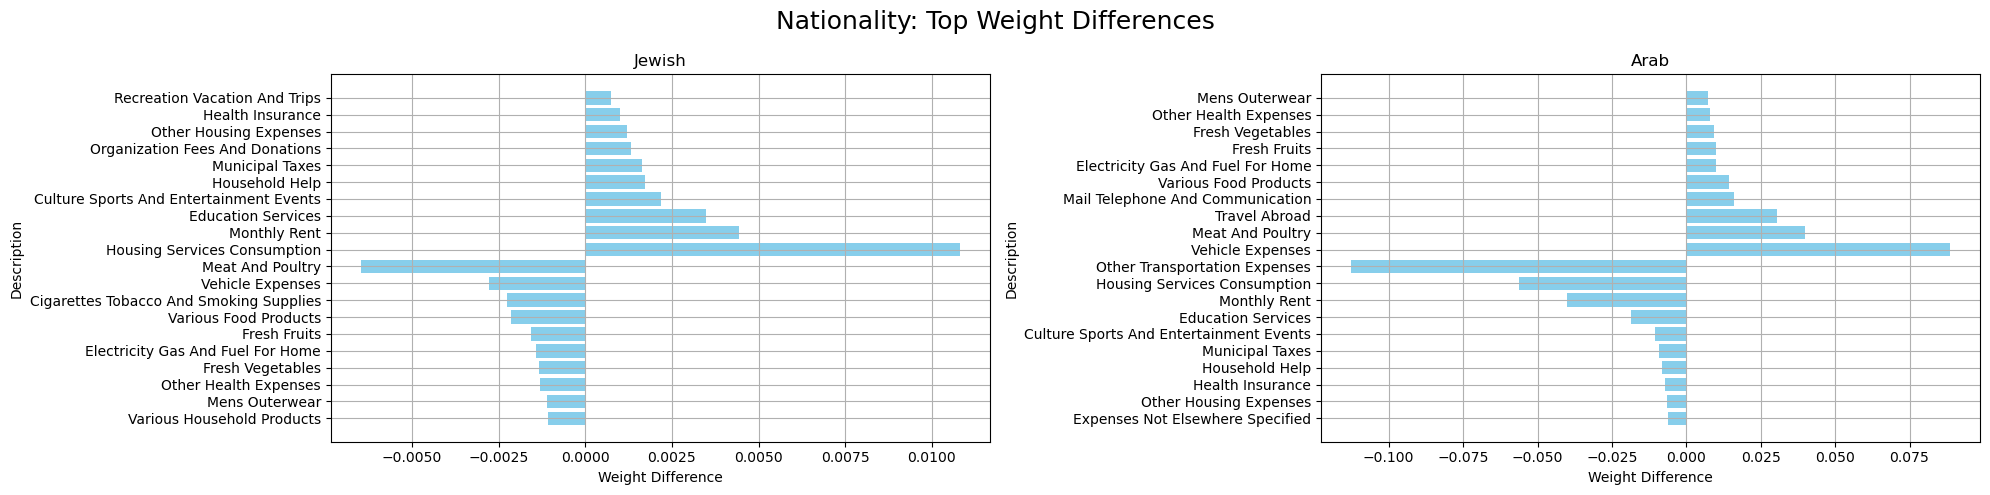

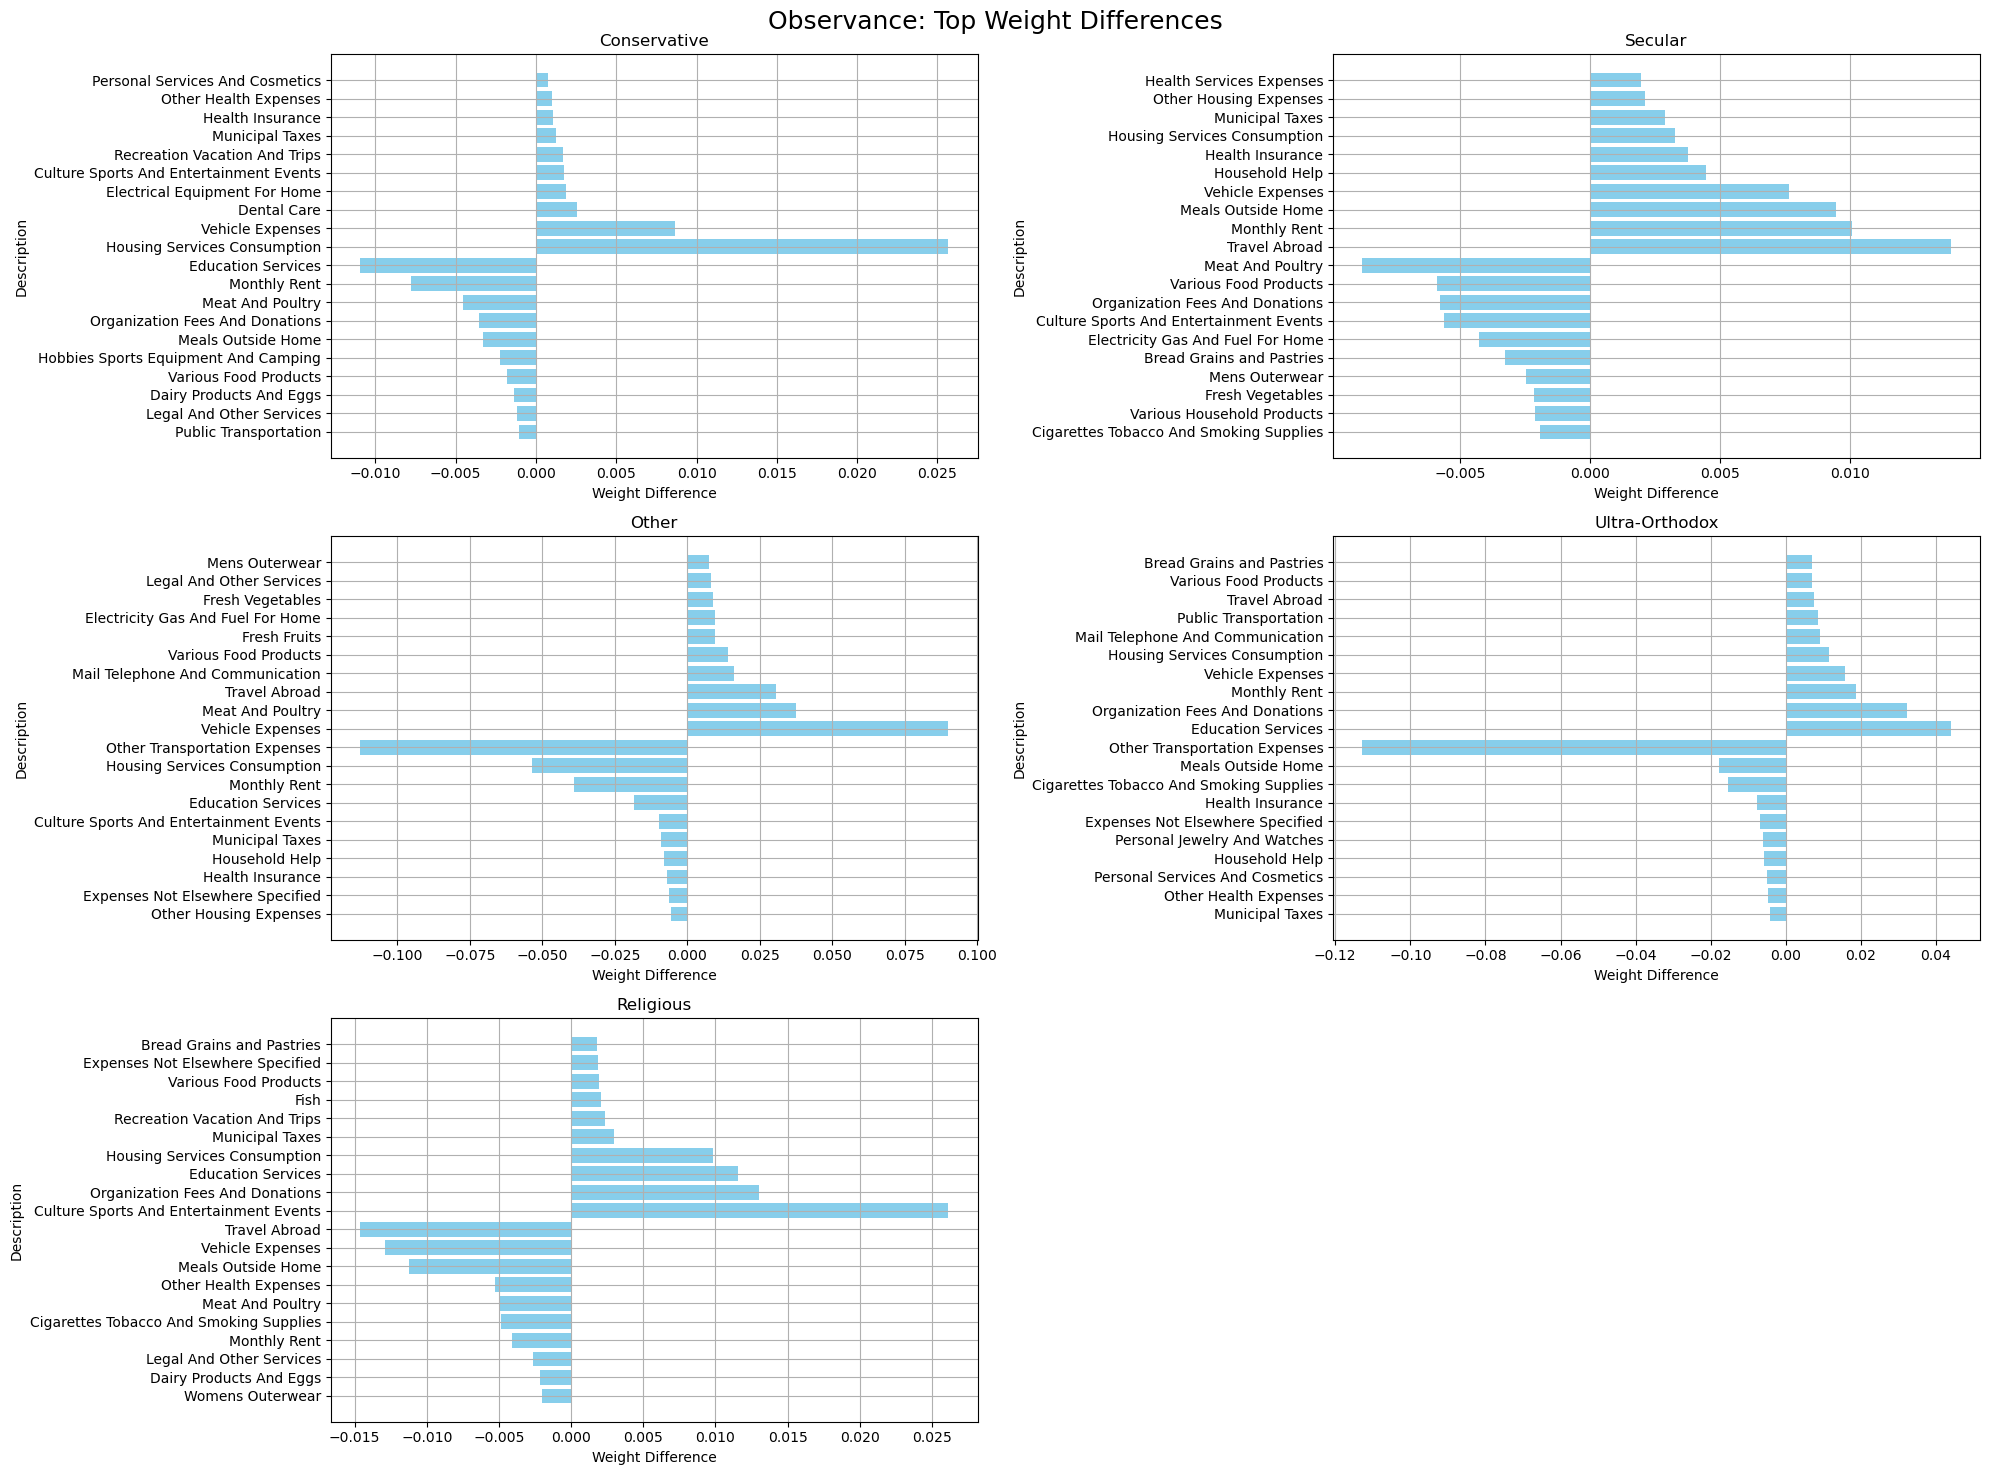

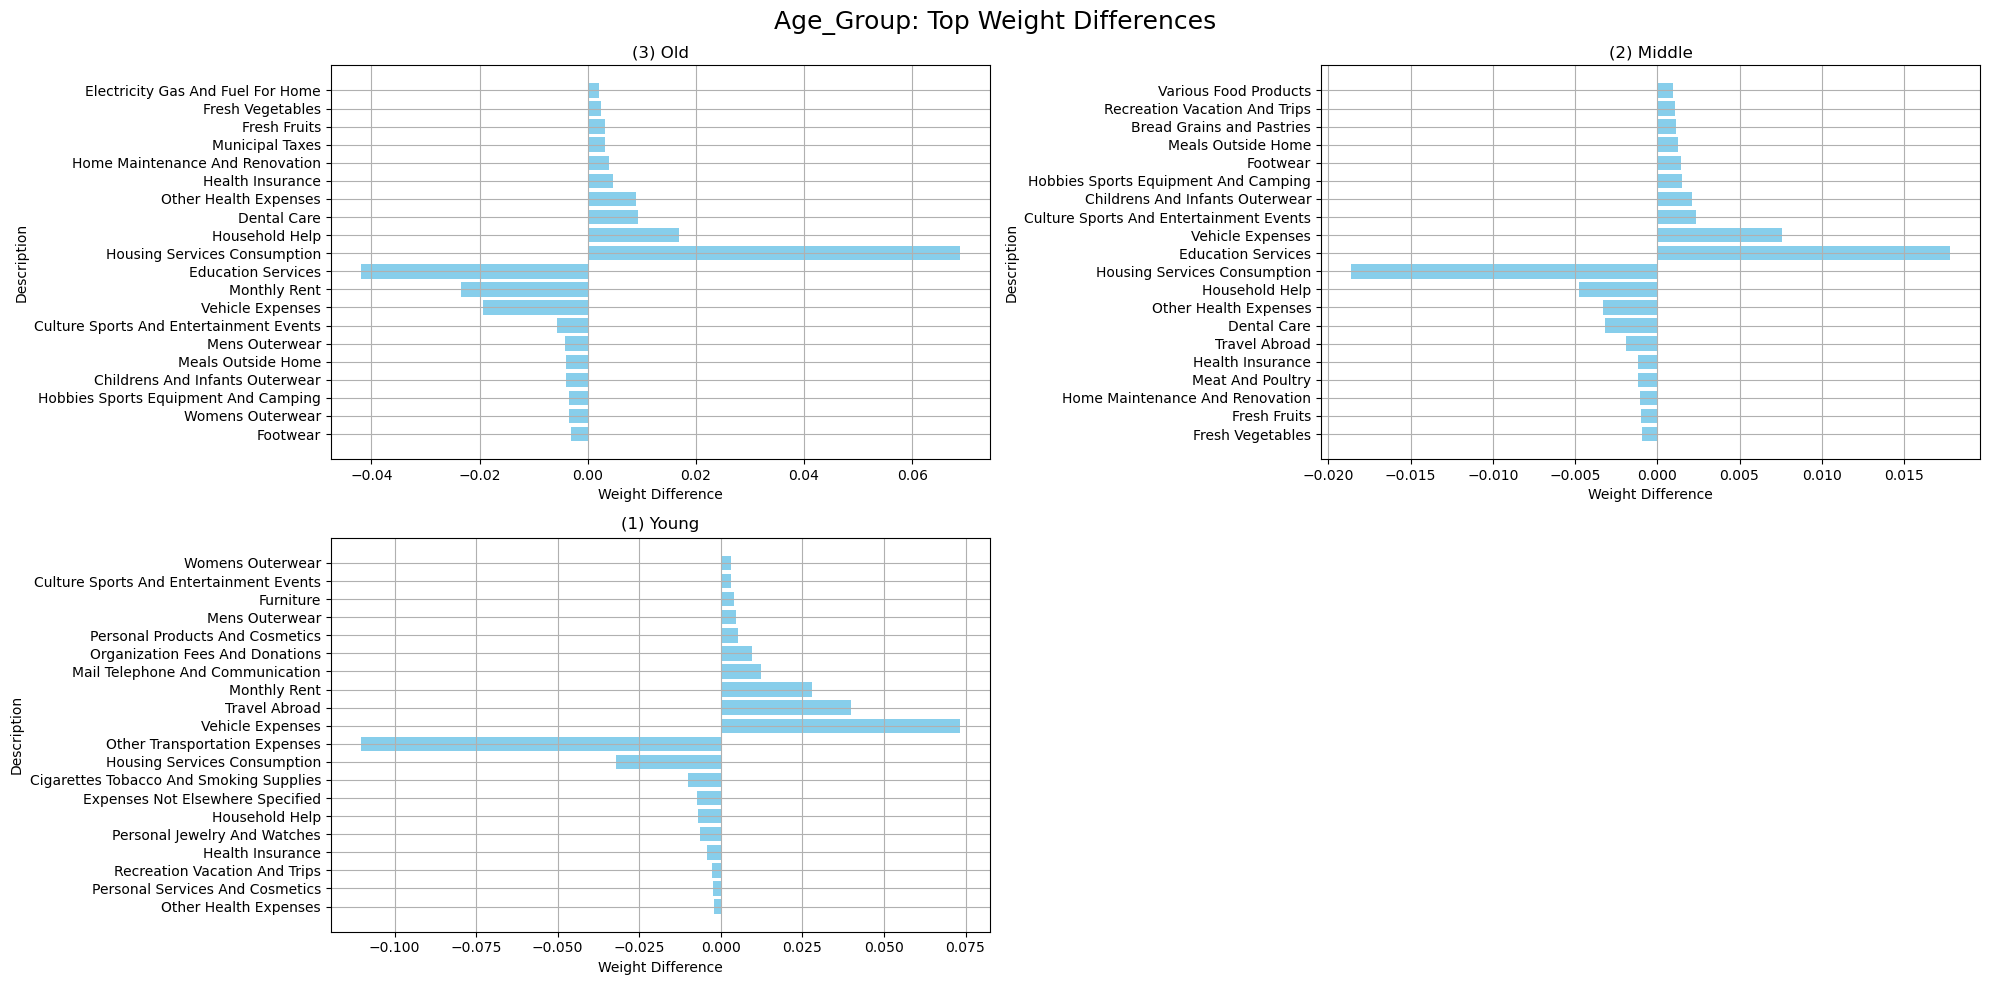

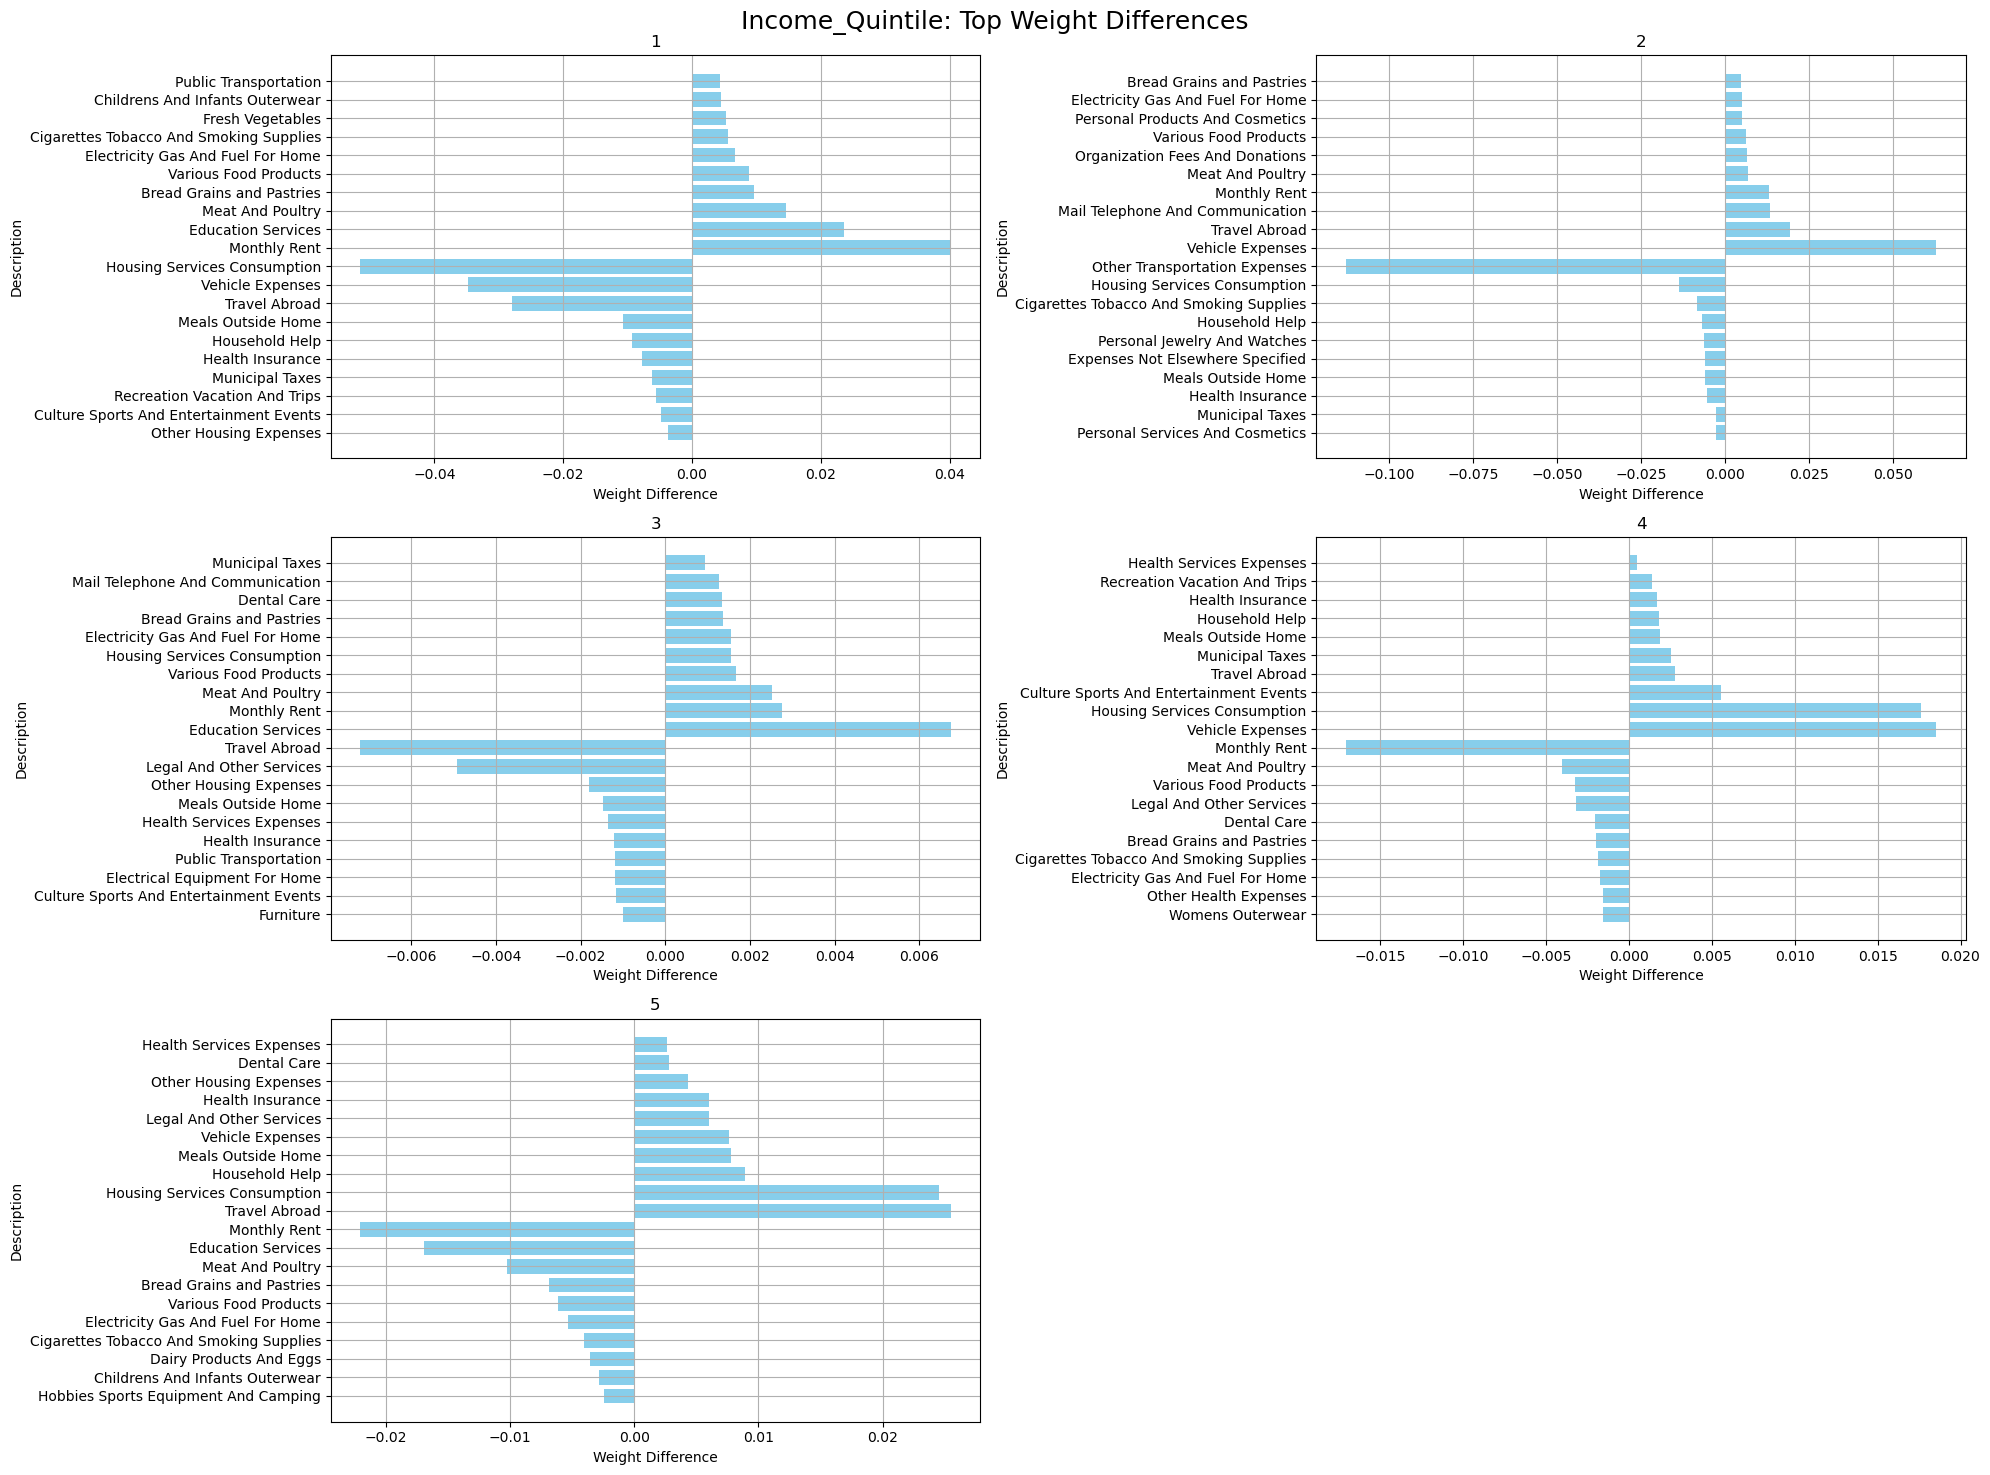

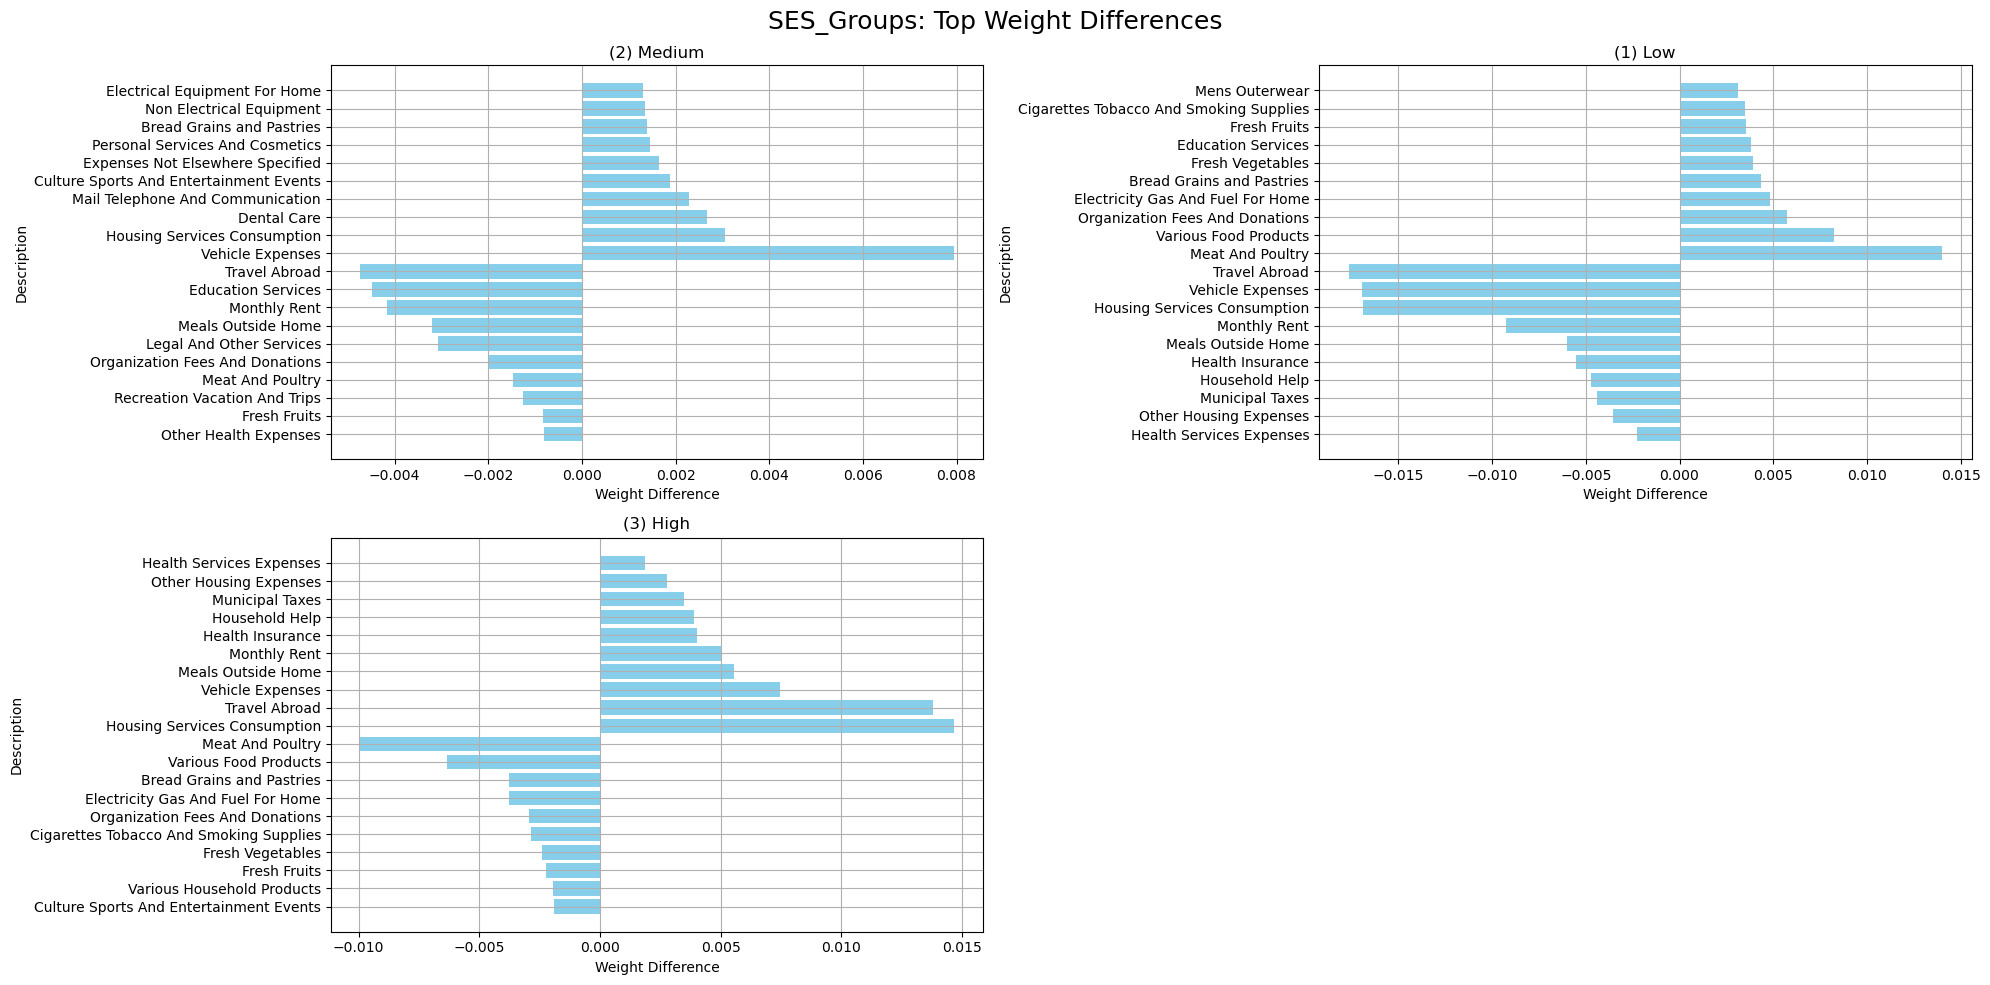

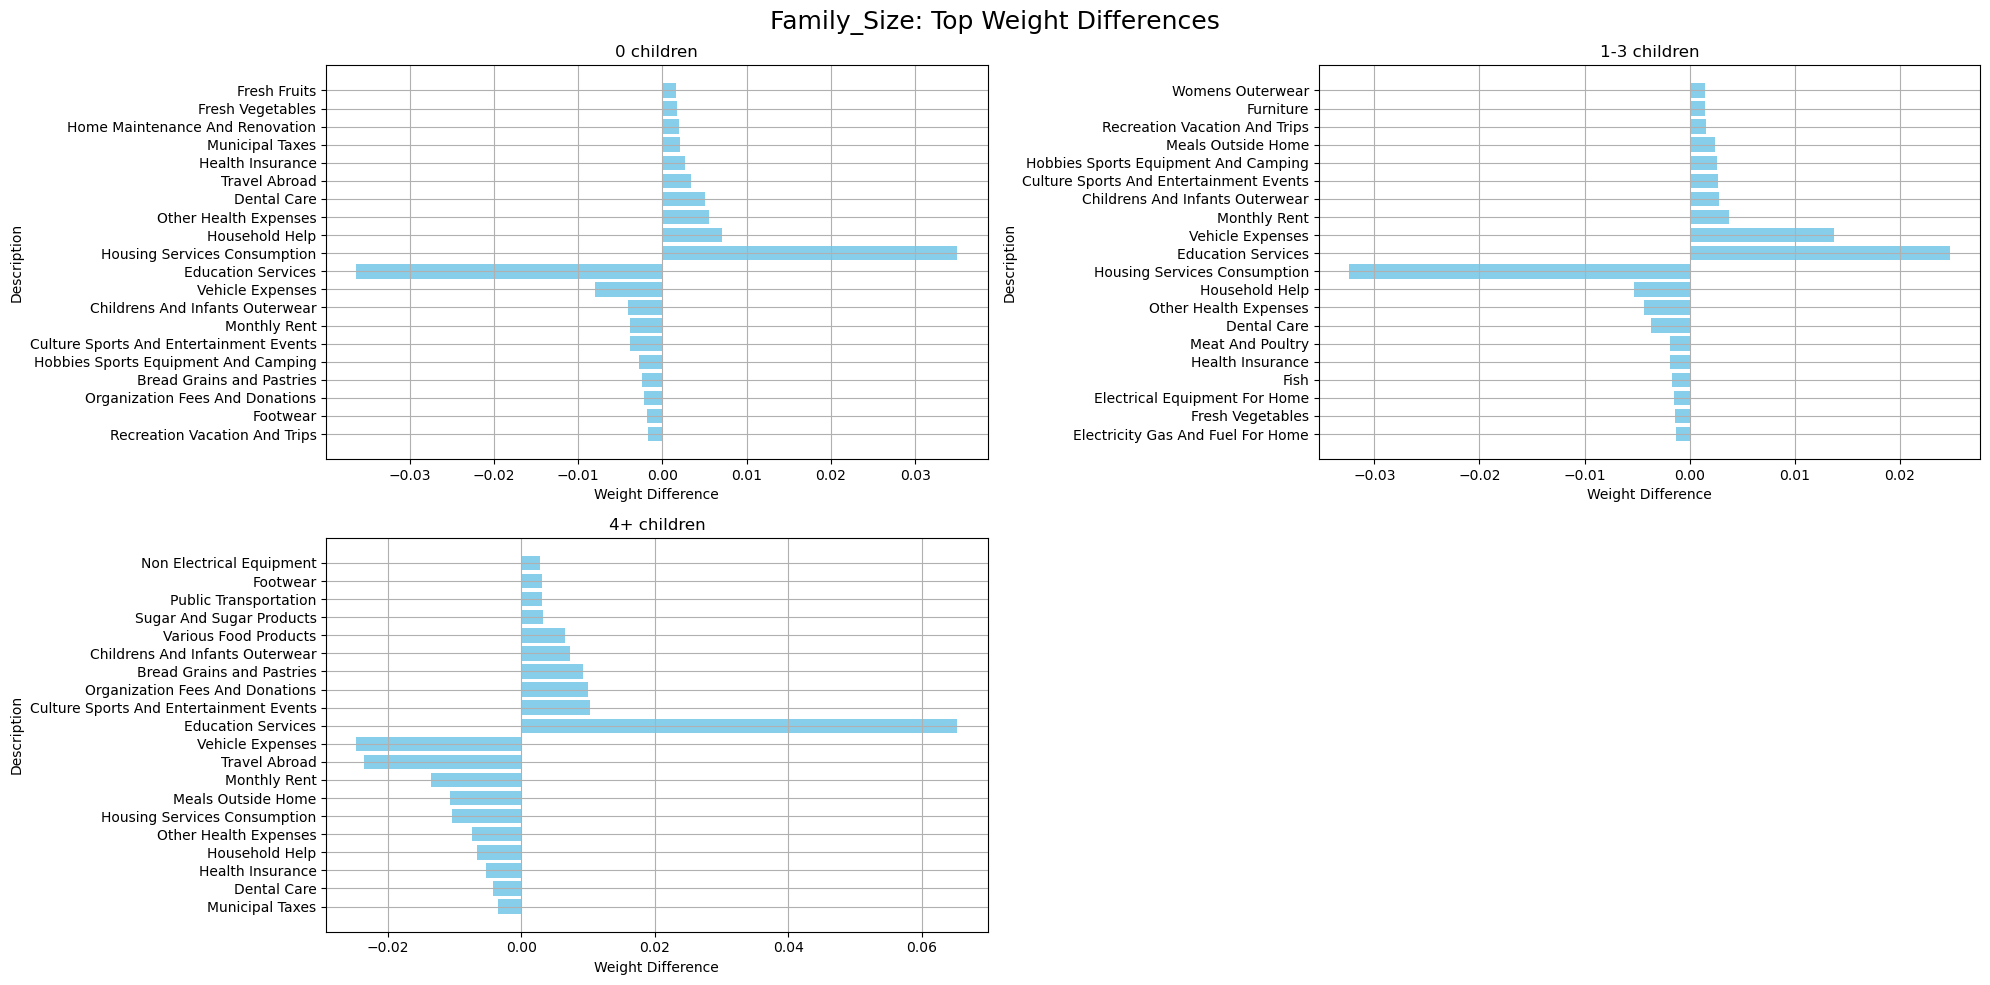

In [238]:
def top_abs_weight_differences(weights, top_n=10):
    import matplotlib.pyplot as plt
    import pandas as pd
    from IPython.display import display, HTML

    for group in weights.keys():
        if group == 'All':
            continue

        subgroups = weights[group].keys()
        try:
            subgroups = sorted(subgroups, key=int)
        except ValueError:
            subgroups = weights[group].keys()
        n_subgroups = len(subgroups)
        ncols = 2
        nrows = (n_subgroups + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows), sharey=False)
        axes = axes.flatten()

        axis_max = 0
        axis_min = 0
        weights_diff_df = {}
        for i, subgroup in enumerate(subgroups):
            # Calculate the weight differences between the subgroup and the control group
            weights_diff_df[subgroup] = weights[group][subgroup].copy()
            weights_diff_df[subgroup]['weight_diff'] = weights_diff_df[subgroup]['weight'] - weights['All']['All']['weight']

            # Sort by the weight differences in descending order
            sorted_weights_diff_df = weights_diff_df[subgroup].sort_values(by='weight_diff', ascending=True)

            # Select the top n positive gaps
            top_n_positive = sorted_weights_diff_df.head(top_n)
            top_n_positive = top_n_positive.iloc[::-1]

            # Sort by the weight differences in ascending order
            sorted_weights_diff_df = weights_diff_df[subgroup].sort_values(by='weight_diff', ascending=False)

            # Select the top n negative gaps
            top_n_negative = sorted_weights_diff_df.head(top_n)

            # Concatenate the positive and negative gaps
            top_n_weights_diff_df = pd.concat([top_n_positive, top_n_negative])
            axis_max = max(axis_max, top_n_weights_diff_df['weight_diff'].max())
            axis_min = min(axis_min, top_n_weights_diff_df['weight_diff'].min())

            # Plot the top n largest gaps
            axes[i].barh(top_n_weights_diff_df['description'], top_n_weights_diff_df['weight_diff'], color='skyblue')
            axes[i].set_title(subgroup)
            axes[i].set_xlabel('Weight Difference')
            axes[i].set_ylabel('Description')
            axes[i].grid(True)

        for ax in axes[len(subgroups):]:
            fig.delaxes(ax)

        fig.suptitle(f"{group}: Top Weight Differences", fontsize=18)
        plt.tight_layout()
        plt.show()

top_abs_weight_differences(price_indexes_secondary[comparison_year], top_n)

In [239]:
# Export to html (optional: --no-input)
!jupyter nbconvert --to html Main.ipynb --no-input --output Main.html

[NbConvertApp] Converting notebook Main.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 3231058 bytes to Main.html
